In [1]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import torch as ch
from torch import Tensor
import torch.nn as nn
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import datetime

## Default Experiment Parameters

In [631]:
# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 10,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'samples': 10000,  # number of samples to generate for ground truth
    'in_features': 1, # number of in-features to multi-log-reg
    'k': 2, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'custom_criterion': F.gumbel_softmax,
    'trials': 10,
})

# Generate Synthetic Data

In [623]:
# generate ground-truth from uniform distribution
U = Uniform(args.lower, args.upper)
ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
if ground_truth.bias is not None: 
    ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
print("ground truth weights: {}".format(ground_truth.weight))
print("ground truth bias: {}".format(ground_truth.bias))
# independent variable 
U_ = Uniform(-5, 5)
X = U_.sample(ch.Size([args.samples, args.IN_FEATURES]))
# determine base model logits 
z = ground_truth(X)
# apply softmax to unnormalized likelihoods
y = ch.argmax(ch.nn.Softmax(dim=1)(z), dim=1)

ground truth weights: Parameter containing:
tensor([[-0.2086],
        [-0.2106]], requires_grad=True)
ground truth bias: Parameter containing:
tensor([ 0.1975, -0.1717], requires_grad=True)


# Algorithm Parameters

In [624]:
# all synthetic data 
ds = TensorDataset(X, y)
# split ds into training and validation data sets
train_length = int(len(ds)*.8)
val_length = len(ds) - train_length
train_ds, val_ds = ch.utils.data.random_split(ds, [train_length, val_length])
# train and validation loaders
train_loader = DataLoader(train_ds, num_workers=args.num_workers, batch_size=args.batch_size)
val_loader = DataLoader(val_ds, num_workers=args.num_workers, batch_size=args.batch_size)
# gradients
gumbel_ce = GumbelCE.apply
ce_loss = nn.CrossEntropyLoss()

# PyTorch CE Loss

In [488]:
# CE LOSS TABLE FOR METRICS
CE_LOSS_TABLE_NAME = 'ce_loss'

STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression'
store = Store(STORE_PATH)

store.add_table(CE_LOSS_TABLE_NAME, { 
    'train_acc': float, ""
    'val_acc': float, 
    'train_loss': float, 
    'val_loss': float,
    'epoch': int,
})

Logging in: /home/pstefanou/MultinomialLogisticRegression/3ae8814e-7019-4115-99ff-f01a61adb1f5


In [489]:
multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
# optimizer and scheduler
optimizer = ch.optim.SGD(multi_log_reg.parameters(), lr=1e-1)
scheduler = ch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)

for i in range(args.trials):
    for epoch in range(args.epochs): 
        # train loop
        train_loss, train_acc = Tensor([]), Tensor([])
        for batch_X, batch_y in train_loader: 
            optimizer.zero_grad()
            pred = multi_log_reg(batch_X)
            loss = ce_loss(pred,  batch_y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            # keep track of algorithm training loss and accuracy
            acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)
            train_loss = ch.cat([train_loss, Tensor([loss])]) if train_loss.size() != ch.Size([0]) else Tensor([loss])
            train_acc = ch.cat([train_acc, Tensor([acc])]) if train_acc.size() != ch.Size([0]) else Tensor([acc])
        # validation loop
        val_loss, val_acc = Tensor([]), Tensor([])
        with ch.no_grad(): 
            for batch_X, batch_y in val_loader: 
                pred = multi_log_reg(batch_X)
                loss = ce_loss(pred, batch_y)
                # keep track of algorithm validation loss and accuracy
                acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)            
                val_loss = ch.cat([val_loss, Tensor([loss])]) if val_loss.size() != ch.Size([0]) else Tensor([loss])
                val_acc = ch.cat([val_acc, Tensor([acc])]) if val_acc.size() != ch.Size([0]) else Tensor([acc])

        store[CE_LOSS_TABLE_NAME].append_row({ 
            'train_acc': float(train_acc.mean()), 
            'val_acc': float(val_acc.mean()), 
            'train_loss': float(train_loss.mean()), 
            'val_loss': float(val_loss.mean()),
            'epoch': int(epoch + 1),
        })
store.close()

# Read Results Experiment

In [490]:
reader = CollectionReader(STORE_PATH)
results = reader.df(CE_LOSS_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 1/1 [00:00<00:00, 63.71it/s]


train_acc  val_acc  train_loss  val_loss  epoch  \
0   0.894625   0.9320    0.302855  0.185647      1   
1   0.940750   0.9525    0.156548  0.145880      2   
2   0.954875   0.9640    0.131026  0.130627      3   
3   0.963125   0.9685    0.116563  0.116246      4   
4   0.969875   0.9715    0.106702  0.108101      5   

                                 exp_id  
0  3ae8814e-7019-4115-99ff-f01a61adb1f5  
1  3ae8814e-7019-4115-99ff-f01a61adb1f5  
2  3ae8814e-7019-4115-99ff-f01a61adb1f5  
3  3ae8814e-7019-4115-99ff-f01a61adb1f5  
4  3ae8814e-7019-4115-99ff-f01a61adb1f5

# Plot Loss and Accuracy Curves

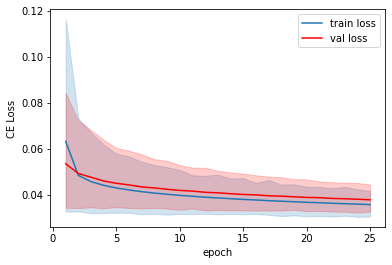

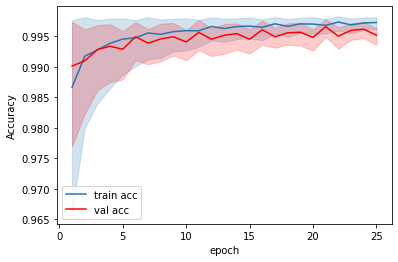

In [491]:
sns.lineplot(data=results, x='epoch', y='train_loss', label='train loss')
ax = sns.lineplot(data=results, x='epoch', y='val_loss', color='red', label='val loss')
ax.set(xlabel='epoch', ylabel='CE Loss')
plt.show()

sns.lineplot(data=results, x='epoch', y='train_acc', label='train acc')
ax = sns.lineplot(data=results, x='epoch', y='val_acc', color='red', label='val acc')
ax.set(xlabel='epoch', ylabel='Accuracy')
plt.show()

# CE Latent Variable Model Loss

In [642]:
gumbel = Gumbel(0, 1)

class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.CrossEntropyLoss()
        calc = loss(pred, targ)
        return calc

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)        
        # add gumbel noise to logits
        noised = stacked + gumbel.sample(stacked.size())
        # remove noisy logits that fall below z_k
        for i in range(noised.size(1)): # iterate over samples within batch
            # get minimum noisy logit for kth class
            z_k_max = ch.max(noised[:, i, int(targ[i])])
            # remove logits that are strictly larger than z_k_min
            for j in range(noised.size(2)):
                if j != targ[i]: 
                    values = noised[:, i, j]
                    noised[:, i, j] = ch.where(values > z_k_max, ch.zeros(1), values) 
        out = noised - stacked
#         print("pred: {}".format(pred.size()))
#         print("out: {}".format(out))
#         out = noised.max(dim = 0)[0]
#         out = noised.sum(dim = 0) / (noised.count_nonzero(dim=0) + 1e-5)
#         print("out: {}".format(out))
        # calculate gradient 
        grad = 1 - ch.exp(-out)
        print("grad: {}".format(grad.size()))
        grad_mean = grad.sum(dim = 0) / (grad.count_nonzero(dim=0) + 1e-5)
        print("grad mean: {}".format(grad_mean))
#         print("grad: {}".format(grad.size()))
#         print("grad: {}".format(grad / pred.size(0)))
        return grad_mean / pred.size(0), None

In [618]:
gumbel = Gumbel(0, 1)

class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.CrossEntropyLoss()
        calc = loss(pred, targ)
        return calc

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)        
        # add gumbel noise to logits
        noised = stacked + gumbel.sample(stacked.size())
        # take the maximum logit for each of the 
#         out = noised.max(dim = 0)[0]
        # average logits over num_samples copies
        out.mean(dim = 0)
        # calculate gradient 
        grad = 1 - ch.exp(-out)
        return grad / pred.size(0), None

In [655]:
# CE LOSS TABLE FOR METRICS
LATENT_CE_TABLE_NAME = 'latent_ce_grad'

STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression'
store = Store(STORE_PATH)

store.add_table(LATENT_CE_TABLE_NAME, { 
    'train_acc': float, 
    'val_acc': float, 
    'train_loss': float, 
    'val_loss': float,
    'epoch': int,
})

Logging in: /home/pstefanou/MultinomialLogisticRegression/f4edeab7-121a-4386-918c-b167ea2a5880


In [ ]:
multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
# optimizer and scheduler
optimizer = ch.optim.SGD(multi_log_reg.parameters(), lr=1e-1)
scheduler = ch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)

for i in range(args.trials):
    for epoch in range(args.epochs): 
        # train loop
        train_loss, train_acc = Tensor([]), Tensor([])
        for batch_X, batch_y in train_loader: 
            optimizer.zero_grad()
            pred = multi_log_reg(batch_X)
            loss = ce_loss(pred, batch_y)
            loss.backward(retain_graph=True) 
            print("softmax grad: {}".format(multi_log_reg.weight.grad))
            optimizer.zero_grad() 
            loss = GumbelCE.apply(pred,  batch_y)
            loss.backward()
            print("latent variable grad: {}".format(multi_log_reg.weight.grad))
            print(("---"))
            optimizer.step()
            scheduler.step()
            # keep track of algorithm training loss and accuracy
            acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)
            train_loss = ch.cat([train_loss, Tensor([loss])]) if train_loss.size() != ch.Size([0]) else Tensor([loss])
            train_acc = ch.cat([train_acc, Tensor([acc])]) if train_acc.size() != ch.Size([0]) else Tensor([acc])
        # validation loop
        val_loss, val_acc = Tensor([]), Tensor([])
        with ch.no_grad(): 
            for batch_X, batch_y in val_loader: 
                pred = multi_log_reg(batch_X)
                loss = gumbel_ce(pred, batch_y)
                # keep track of algorithm validation loss and accuracy
                acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)            
                val_loss = ch.cat([val_loss, Tensor([loss])]) if val_loss.size() != ch.Size([0]) else Tensor([loss])
                val_acc = ch.cat([val_acc, Tensor([acc])]) if val_acc.size() != ch.Size([0]) else Tensor([acc])

        store[LATENT_CE_TABLE_NAME].append_row({ 
            'train_acc': float(train_acc.mean()), 
            'val_acc': float(val_acc.mean()), 
            'train_loss': float(train_loss.mean()), 
            'val_loss': float(val_loss.mean()),
            'epoch': int(epoch + 1),
        })
store.close()

softmax grad: tensor([[-0.9278],
        [ 0.9278]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.9312],
        [ 0.9362]])
---
softmax grad: tensor([[-0.9470],
        [ 0.9470]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.9595],
        [ 0.9838]])
---
softmax grad: tensor([[-1.7819],
        [ 1.7819]])
torch.Size([1000, 10])
latent variable grad: tensor([[-1.8328],
        [ 1.7476]])
---
softmax grad: tensor([[ 0.0145],
        [-0.0145]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0317],
        [0.0122]])
---
softmax grad: tensor([[-0.1183],
        [ 0.1183]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.1163],
        [ 0.0890]])
---
softmax grad: tensor([[ 1.5876],
        [-1.5876]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 1.5466],
        [-1.6433]])
---
softmax grad: tensor([[ 0.1514],
        [-0.1514]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.1743],
        [-0.1318]])
---
softmax grad: t

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0560],
        [ 0.0442]])
---
softmax grad: tensor([[-0.2611],
        [ 0.2611]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.2624],
        [ 0.1898]])
---
softmax grad: tensor([[ 0.2182],
        [-0.2182]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.1711],
        [-0.2439]])
---
softmax grad: tensor([[-0.0509],
        [ 0.0509]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0515],
        [ 0.0369]])
---
softmax grad: tensor([[ 0.0768],
        [-0.0768]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.1336],
        [-0.1175]])
---
softmax grad: tensor([[ 0.0034],
        [-0.0034]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0282],
        [-0.0330]])
---
softmax grad: tensor([[ 0.0432],
        [-0.0432]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0432],
        [-0.0458]])
---
softmax grad: tensor([[ 0.0175],
        [-0.0175]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0118],
        [ 0.0538]])
---
softmax grad: tensor([[-0.0934],
        [ 0.0934]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0512],
        [ 0.0298]])
---
softmax grad: tensor([[ 0.0498],
        [-0.0498]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0042],
        [-0.0601]])
---
softmax grad: tensor([[-0.0238],
        [ 0.0238]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0278],
        [-0.0286]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0005],
        [-0.0631]])
---
softmax grad: tensor([[ 0.0300],
        [-0.0300]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0403],
        [-0.0265]])
---
softmax grad: tensor([[ 0.0692],
        [-0.0692]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0873],
        [-0.0793]])
---
softmax grad: tensor([[ 0.0775],
        [-0.0775]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0573],
        [-0.1160]])
---
softmax grad: tensor([[-0.0442],
        [ 0.0442]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0349],
        [ 0.0302]])
---
softmax grad: tensor([[ 0.0369],
        [-0.0369]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.1035],
        [0.0271]])
---
softmax grad: tensor([[-0.0701],
        [ 0.0701]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0882],
        [ 0.0647]])
---
softmax grad: tensor([[ 0.0318],
        [-0.0318]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0523],
        [-0.0467]])
---
softmax grad: tensor([[ 0.0050],
        [-0.0050]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0188],
        [0.0116]])
---
softmax grad: tensor([[-0.0452],
        [ 0.0452]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.1012],
        [ 0.0554]])
---
softmax grad: tensor([[ 0.0060],
        [-0.0060]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0500],
        [ 0.0506]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0103],
        [-0.0389]])
---
softmax grad: tensor([[ 0.0261],
        [-0.0261]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0074],
        [-0.0378]])
---
softmax grad: tensor([[-0.0395],
        [ 0.0395]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0179],
        [ 0.0746]])
---
softmax grad: tensor([[-0.0179],
        [ 0.0179]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0019],
        [-0.0166]])
---
softmax grad: tensor([[ 0.0385],
        [-0.0385]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0663],
        [-0.0244]])
---
softmax grad: tensor([[-0.0417],
        [ 0.0417]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0555],
        [ 0.0440]])
---
softmax grad: tensor([[ 0.0256],
        [-0.0256]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[0.0286],
        [0.0524]])
---
softmax grad: tensor([[ 0.0181],
        [-0.0181]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0543],
        [-0.0387]])
---
softmax grad: tensor([[ 0.0217],
        [-0.0217]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0219],
        [-0.0280]])
---
softmax grad: tensor([[ 3.3562e-05],
        [-3.3584e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0769],
        [-0.0302]])
---
softmax grad: tensor([[-0.0038],
        [ 0.0038]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0070],
        [-0.0181]])
---
softmax grad: tensor([[ 0.0273],
        [-0.0273]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0438],
        [-0.0346]])
---
softmax grad: tensor([[ 0.0466],
        [-0.0466]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0971],
        [-0.0716]])
---
softmax grad: tensor([[-0.0157],
        [ 0.0157]])
torch.S

latent variable grad: tensor([[-0.0176],
        [ 0.0169]])
---
softmax grad: tensor([[-0.0039],
        [ 0.0039]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0400],
        [-0.0169]])
---
softmax grad: tensor([[ 0.0074],
        [-0.0074]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0380],
        [-0.0087]])
---
softmax grad: tensor([[-0.0152],
        [ 0.0152]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0410],
        [ 0.0102]])
---
softmax grad: tensor([[ 0.0154],
        [-0.0154]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0103],
        [ 0.0169]])
---
softmax grad: tensor([[ 0.0030],
        [-0.0030]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0084],
        [-0.0217]])
---
softmax grad: tensor([[-0.0046],
        [ 0.0046]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0096],
        [-0.0140]])
---
softmax grad: tensor([[ 0.0042],
        [-0.0042]])
torch.Size([1000, 10])
latent variab

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0170],
        [ 0.0423]])
---
softmax grad: tensor([[ 0.0046],
        [-0.0046]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0013],
        [0.0011]])
---
softmax grad: tensor([[-0.0060],
        [ 0.0060]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0190],
        [-0.0109]])
---
softmax grad: tensor([[-0.0257],
        [ 0.0257]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0796],
        [ 0.0736]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0012],
        [ 0.0404]])
---
softmax grad: tensor([[-0.0371],
        [ 0.0371]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0038],
        [ 0.0954]])
---
softmax grad: tensor([[ 0.0032],
        [-0.0032]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0326],
        [-0.0321]])
---
softmax grad: tensor([[-0.0258],
        [ 0.0258]])
torch.Size([100

---
softmax grad: tensor([[-0.0205],
        [ 0.0205]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0002],
        [0.0082]])
---
softmax grad: tensor([[-0.0052],
        [ 0.0052]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0017],
        [ 0.0245]])
---
softmax grad: tensor([[ 0.0031],
        [-0.0031]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0315],
        [0.0037]])
---
softmax grad: tensor([[ 0.0192],
        [-0.0192]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0377],
        [-0.0013]])
---
softmax grad: tensor([[-0.0179],
        [ 0.0179]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0593],
        [ 0.0134]])
---
softmax grad: tensor([[ 0.0150],
        [-0.0150]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0248],
        [ 0.0344]])
---
softmax grad: tensor([[ 0.0197],
        [-0.0197]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0201],
        [0.0023]])
---
softmax grad: t

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0595],
        [-0.0073]])
---
softmax grad: tensor([[ 0.0345],
        [-0.0345]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0253],
        [-0.0278]])
---
softmax grad: tensor([[ 0.0028],
        [-0.0028]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0070],
        [ 0.0399]])
---
softmax grad: tensor([[ 0.0034],
        [-0.0034]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0063],
        [ 0.0283]])
---
softmax grad: tensor([[-0.0127],
        [ 0.0127]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0168],
        [-0.0238]])
---
softmax grad: tensor([[ 0.0034],
        [-0.0034]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0368],
        [ 0.0253]])
---
softmax grad: tensor([[ 0.0098],
        [-0.0098]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0336],
        [ 0.0436]])
---
softmax grad: tensor([[ 0.0133],
        [-0.0133]])
torch.Size([1

---
softmax grad: tensor([[-0.0178],
        [ 0.0178]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0167],
        [ 0.0458]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0118],
        [-0.0430]])
---
softmax grad: tensor([[ 0.0057],
        [-0.0057]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0074],
        [ 0.0017]])
---
softmax grad: tensor([[ 0.0113],
        [-0.0113]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0085],
        [0.0206]])
---
softmax grad: tensor([[ 0.0077],
        [-0.0077]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0236],
        [-0.0214]])
---
softmax grad: tensor([[ 0.0024],
        [-0.0024]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0214],
        [-0.0203]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0257],
        [-0.0364]])
---
softmax gra

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0102],
        [-0.0064]])
---
softmax grad: tensor([[-0.0095],
        [ 0.0095]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0089],
        [0.0220]])
---
softmax grad: tensor([[-0.0029],
        [ 0.0029]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0042],
        [-0.0290]])
---
softmax grad: tensor([[ 0.0050],
        [-0.0050]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0358],
        [-0.0371]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0214],
        [-0.0097]])
---
softmax grad: tensor([[-0.0056],
        [ 0.0056]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0054],
        [0.0151]])
---
softmax grad: tensor([[-0.0045],
        [ 0.0045]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0563],
        [0.0114]])
---
softmax grad: tensor([[-0.0165],
        [ 0.0165]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[0.0149],
        [0.0204]])
---
softmax grad: tensor([[-0.0137],
        [ 0.0137]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0140],
        [-0.0283]])
---
softmax grad: tensor([[ 3.6793e-05],
        [-3.6841e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0070],
        [ 0.0365]])
---
softmax grad: tensor([[ 0.0115],
        [-0.0115]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0015],
        [-0.0108]])
---
softmax grad: tensor([[-0.0057],
        [ 0.0057]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0362],
        [ 0.0093]])
---
softmax grad: tensor([[-0.0049],
        [ 0.0049]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0532],
        [ 0.0042]])
---
softmax grad: tensor([[-0.0023],
        [ 0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0040],
        [0.0090]])
---
softmax grad: tensor([[-0.0019],
        [ 0.0019]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0077],
        [-0.0282]])
---
softmax grad: tensor([[-0.0026],
        [ 0.0026]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0051],
        [ 0.0260]])
---
softmax grad: tensor([[ 0.0105],
        [-0.0105]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0126],
        [0.0007]])
---
softmax grad: tensor([[ 0.0107],
        [-0.0107]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0034],
        [ 0.0243]])
---
softmax grad: tensor([[ 0.0157],
        [-0.0157]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0136],
        [-0.0263]])
---
softmax grad: tensor([[ 0.0155],
        [-0.0155]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0134],
        [-0.0614]])
---
softmax grad: tensor([[-0.0037],
        [ 0.0037]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0241],
        [0.0155]])
---
softmax grad: tensor([[-0.0106],
        [ 0.0106]])
torch.Size([1000,

latent variable grad: tensor([[-0.0196],
        [-0.0159]])
---
softmax grad: tensor([[-0.0032],
        [ 0.0032]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0417],
        [-0.0040]])
---
softmax grad: tensor([[ 0.0103],
        [-0.0103]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0010],
        [0.0189]])
---
softmax grad: tensor([[-0.0194],
        [ 0.0194]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0477],
        [-0.0152]])
---
softmax grad: tensor([[ 0.0087],
        [-0.0087]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0350],
        [-0.0285]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0281],
        [ 0.0351]])
---
softmax grad: tensor([[ 0.0085],
        [-0.0085]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0269],
        [-0.0213]])
---
softmax grad: tensor([[ 0.0052],
        [-0.0052]])
torch.Size([1000, 10])
latent variable

torch.Size([1000, 10])
latent variable grad: tensor([[0.0114],
        [0.0169]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0371],
        [ 0.0078]])
---
softmax grad: tensor([[ 0.0106],
        [-0.0106]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0326],
        [0.0068]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0616],
        [ 0.0441]])
---
softmax grad: tensor([[ 0.0032],
        [-0.0032]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0132],
        [0.0439]])
---
softmax grad: tensor([[ 0.0043],
        [-0.0043]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0123],
        [-0.0160]])
---
softmax grad: tensor([[ 0.0075],
        [-0.0075]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0112],
        [-0.0101]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 1

---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0545],
        [ 0.0343]])
---
softmax grad: tensor([[-0.0099],
        [ 0.0099]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0011],
        [-0.0047]])
---
softmax grad: tensor([[ 0.0168],
        [-0.0168]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0168],
        [-0.0513]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0222],
        [-0.0324]])
---
softmax grad: tensor([[ 0.0208],
        [-0.0208]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0225],
        [ 0.0213]])
---
softmax grad: tensor([[-0.0030],
        [ 0.0030]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0064],
        [-0.0111]])
---
softmax grad: tensor([[-0.0086],
        [ 0.0086]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0406],
        [ 0.0218]])
---
softmax g

latent variable grad: tensor([[0.0058],
        [0.0008]])
---
softmax grad: tensor([[-0.0095],
        [ 0.0095]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0210],
        [0.0335]])
---
softmax grad: tensor([[-0.0047],
        [ 0.0047]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0022],
        [0.0363]])
---
softmax grad: tensor([[-0.0096],
        [ 0.0096]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0166],
        [-0.0370]])
---
softmax grad: tensor([[-0.0063],
        [ 0.0063]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0207],
        [ 0.0402]])
---
softmax grad: tensor([[ 0.0020],
        [-0.0020]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0280],
        [-0.0493]])
---
softmax grad: tensor([[ 0.0094],
        [-0.0094]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0922],
        [0.0109]])
---
softmax grad: tensor([[-0.0082],
        [ 0.0082]])
torch.Size([1000, 10])
latent variable grad:

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0309],
        [-0.0239]])
---
softmax grad: tensor([[ 0.0056],
        [-0.0056]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0101],
        [0.0104]])
---
softmax grad: tensor([[ 0.0096],
        [-0.0096]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0104],
        [-0.0038]])
---
softmax grad: tensor([[-0.0059],
        [ 0.0059]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0074],
        [ 0.0230]])
---
softmax grad: tensor([[-0.0055],
        [ 0.0055]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0338],
        [-0.0213]])
---
softmax grad: tensor([[-0.0022],
        [ 0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0206],
        [ 0.0439]])
---
softmax grad: tensor([[-0.0025],
        [ 0.0025]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0246],
        [0.0055]])
---
softmax grad: tensor([[ 0.0031],
        [-0.0031]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0185],
        [-0.0293]])
---
softmax grad: tensor([[ 0.0035],
        [-0.0035]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0020],
        [ 0.0091]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0241],
        [-0.0523]])
---
softmax grad: tensor([[ 0.0024],
        [-0.0024]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0049],
        [0.0189]])
---
softmax grad: tensor([[-0.0016],
        [ 0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0152],
        [ 0.0186]])
---
softmax grad: tensor([[ 0.0042],
        [-0.0042]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0054],
        [-0.0148]])
---
softmax grad: tensor([[-0.0059],
        [ 0.0059]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0153],
        [-0.0123]])
---
softmax grad: tensor([[ 0.0086],
        [-0.0086]])
torch.Size([100

softmax grad: tensor([[-0.0045],
        [ 0.0045]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0024],
        [-0.0183]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0420],
        [-0.0193]])
---
softmax grad: tensor([[ 0.0034],
        [-0.0034]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0705],
        [0.0031]])
---
softmax grad: tensor([[ 0.0035],
        [-0.0035]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0510],
        [-0.0236]])
---
softmax grad: tensor([[ 0.0090],
        [-0.0090]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0144],
        [ 0.0339]])
---
softmax grad: tensor([[-0.0119],
        [ 0.0119]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0170],
        [ 0.0243]])
---
softmax grad: tensor([[-0.0101],
        [ 0.0101]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0118],
        [ 0.0551]])
---
softmax grad: t

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0089],
        [ 0.0444]])
---
softmax grad: tensor([[-0.0087],
        [ 0.0087]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0069],
        [-0.0118]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0485],
        [-0.0230]])
---
softmax grad: tensor([[ 0.0022],
        [-0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0238],
        [-0.0106]])
---
softmax grad: tensor([[-0.0106],
        [ 0.0106]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0059],
        [-0.0470]])
---
softmax grad: tensor([[-0.0041],
        [ 0.0041]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0424],
        [ 0.0389]])
---
softmax grad: tensor([[-0.0031],
        [ 0.0031]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0287],
        [ 0.0181]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0159],
        [ 0.0341]])
---
softmax grad: tensor([[-0.0028],
        [ 0.0028]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0410],
        [-0.0189]])
---
softmax grad: tensor([[-0.0065],
        [ 0.0065]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0004],
        [0.0019]])
---
softmax grad: tensor([[ 0.0105],
        [-0.0105]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0329],
        [-0.0010]])
---
softmax grad: tensor([[-0.0048],
        [ 0.0048]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0088],
        [-0.0106]])
---
softmax grad: tensor([[-0.0024],
        [ 0.0024]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0134],
        [-0.0096]])
---
softmax grad: tensor([[ 0.0044],
        [-0.0044]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0287],
        [-0.0020]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([100

latent variable grad: tensor([[0.0021],
        [0.0440]])
---
softmax grad: tensor([[ 0.0041],
        [-0.0041]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0029],
        [ 0.0078]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0217],
        [-0.0560]])
---
softmax grad: tensor([[-0.0037],
        [ 0.0037]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0136],
        [ 0.0346]])
---
softmax grad: tensor([[-0.0025],
        [ 0.0025]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0294],
        [-0.0171]])
---
softmax grad: tensor([[ 0.0021],
        [-0.0021]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0066],
        [-0.0248]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0102],
        [-0.0284]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0277],
        [ 0.0161]])
---
softmax grad: tensor([[-0.0089],
        [ 0.0089]])
torch.Size([1000, 10])
latent variable grad: tensor([[-1.2032e-03],
        [ 5.1102e-05]])
---
softmax grad: tensor([[-0.0062],
        [ 0.0062]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0229],
        [ 0.0115]])
---
softmax grad: tensor([[-0.0057],
        [ 0.0057]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0163],
        [-0.0051]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0211],
        [-0.0118]])
---
softmax grad: tensor([[-0.0046],
        [ 0.0046]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0084],
        [-0.0286]])
---
softmax grad: tensor([[ 0.0056],
        [-0.0056]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0225],
        [-0.0141]])
---
softmax grad: tensor([[ 0.0036],
        [-0.0036]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0226],
        [-0.0329]])
---
softmax grad: tensor([[-0.0032],
        [ 0.0032]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0004],
        [-0.0210]])
---
softmax grad: tensor([[ 0.0070],
        [-0.0070]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0216],
        [-0.0061]])
---
softmax grad: tensor([[-0.0084],
        [ 0.0084]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0053],
        [ 0.0229]])
---
softmax grad: tensor([[-0.0019],
        [ 0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0024],
        [-0.0051]])
---
softmax grad: tensor([[-0.0082],
        [ 0.0082]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0569],
        [-0.0439]])
---
softmax grad: tensor([[ 0.0078],
        [-0.0078]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0596],
        [-0.0227]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0266],
        [-0.0044]])
---
softmax grad: tensor([[-0.0027],
        [ 0.0027]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0259],
        [ 0.0389]])
---
softmax grad: tensor([[-0.0059],
        [ 0.0059]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0103],
        [-0.0069]])
---
softmax grad: tensor([[-0.0037],
        [ 0.0037]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0318],
        [ 0.0477]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0606],
        [0.0374]])
---
softmax grad: tensor([[ 0.0064],
        [-0.0064]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0434],
        [0.0321]])
---
softmax grad: tensor([[-0.0048],
        [ 0.0048]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0244],
        [ 0.0257]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0722],
        [ 0.0013]])
---
softmax grad: tensor([[-0.0019],
        [ 0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0058],
        [ 0.0137]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0223],
        [ 0.0136]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0038],
        [ 0.0242]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0102],
        [0.0459]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0598],
        [0.0183]])
---
softmax grad: tensor([[ 0.0027],
        [-0.0027]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0322],
        [ 0.0934]])
---
softmax grad: tensor([[ 0.0039],
        [-0.0039]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0095],
        [-0.0038]])
---
softmax grad: tensor([[ 0.0036],
        [-0.0036]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0242],
        [0.0037]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0012],
        [-0.0095]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0255],
        [-0.0275]])
---
softmax grad: tensor([[ 0.0038],
        [-0.0038]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0382],
        [ 0.0255]])
---
softmax grad: tensor([[ 0.0082],
        [-0.0082]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0109],
        [ 0.0211]])
---
softmax grad: tensor([[-0.0028],
        [ 0.0028]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0002],
        [0.0404]])
---
softmax grad: tensor([[-0.0013],
        [ 0.0013]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0075],
        [-0.0074]])
---
softmax grad: tensor([[ 0.0024],
        [-0.0024]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0090],
        [0.0121]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0759],
        [0.0356]])
---
softmax grad: tensor([[-0.0034],
        [ 0.0034]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0111],
        [-0.0097]])
---
softmax grad: tensor([[-0.0064],
        [ 0.0064]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0136],
        [-0.0354]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0432],
        [ 0.0216]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0877],
        [-0.0174]])
---
softmax grad: tensor([[-0.0031],
        [ 0.0031]])
torch.Size([1000,

softmax grad: tensor([[-0.0020],
        [ 0.0020]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0039],
        [ 0.0030]])
---
softmax grad: tensor([[ 0.0035],
        [-0.0035]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0175],
        [-0.0139]])
---
softmax grad: tensor([[ 0.0020],
        [-0.0020]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0156],
        [0.0157]])
---
softmax grad: tensor([[ 0.0036],
        [-0.0036]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0139],
        [ 0.0179]])
---
softmax grad: tensor([[-0.0046],
        [ 0.0046]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0088],
        [0.0027]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0030],
        [-0.0060]])
---
softmax grad: tensor([[ 0.0050],
        [-0.0050]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0212],
        [ 0.0553]])
---
softmax grad: ten

torch.Size([1000, 10])
latent variable grad: tensor([[0.0332],
        [0.0173]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0308],
        [ 0.0178]])
---
softmax grad: tensor([[ 0.0050],
        [-0.0050]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0526],
        [0.0507]])
---
softmax grad: tensor([[ 0.0048],
        [-0.0048]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0075],
        [-0.0028]])
---
softmax grad: tensor([[ 0.0070],
        [-0.0070]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0335],
        [0.0342]])
---
softmax grad: tensor([[ 0.0067],
        [-0.0067]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0034],
        [-0.0552]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0012],
        [ 0.0053]])
---
softmax grad: tensor([[-0.0037],
        [ 0.0037]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0362],
        [-0.0365]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0066],
        [-0.0019]])
---
softmax grad: tensor([[ 0.0036],
        [-0.0036]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0053],
        [0.0067]])
---
softmax grad: tensor([[ 0.0021],
        [-0.0021]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0107],
        [-0.0007]])
---
softmax grad: tensor([[-0.0044],
        [ 0.0044]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0161],
        [0.0071]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0058],
        [0.0287]])
---
softmax grad: tensor([[ 0.0060],
        [-0.0060]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0643],
        [-0.0116]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0483],
        [ 0.0092]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0467],
        [-0.0026]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0092],
        [-0.0137]])
---
softmax grad: tensor([[-0.0029],
        [ 0.0029]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0050],
        [-0.0112]])
---
softmax grad: tensor([[-0.0015],
        [ 0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0045],
        [0.0062]])
---
softmax grad: tensor([[ 0.0032],
        [-0.0032]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0113],
        [-0.0057]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0032],
        [-0.0201]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0604],
        [-0.0135]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0025],
        [-0.0058]])
---
softmax grad: tensor([[ 0.0062],
        [-0.0062]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0611],
        [0.0243]])
---
softmax grad: tensor([[ 0.0028],
        [-0.0028]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0003],
        [-0.0418]])
---
softmax grad: tensor([[-0.0018],
        [ 0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0322],
        [ 0.0036]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0116],
        [0.0104]])
---
softmax grad: tensor([[ 0.0034],
        [-0.0034]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0106],
        [-0.0075]])
---
softmax grad: tensor([[-0.0029],
        [ 0.0029]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0288],
        [-0.0029]])
---
softmax grad: tensor([[ 0.0044],
        [-0.0044]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0123],
        [0.0133]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0254],
        [-0.0312]])
---
softmax grad: tensor([[ 0.0066],
        [-0.0066]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0529],
        [-0.0629]])
---
softmax grad: tensor([[ 0.0031],
        [-0.0031]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0361],
        [ 0.0193]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0414],
        [-0.0005]])
---
softmax grad: tensor([[ 0.0028],
        [-0.0028]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0087],
        [0.0143]])
---
softmax grad: tensor([[-0.0038],
        [ 0.0038]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0132],
        [-0.0289]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0268],
        [-0.0021]])
---
softmax grad: tensor([[ 0.0088],
        [-0.0088]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0047],
        [ 0.0164]])
---
softmax grad: tensor([[ 0.0112],
        [-0.0112]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0091],
        [-0.0032]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0152],
        [ 0.0235]])
---
softmax grad: tensor([[ 0.0032],
        [-0.0032]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0067],
        [-0.0538]])
---
softmax grad: tensor([[-0.0020],
        [ 0.0020]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0481],
        [ 0.0311]])
---
softmax grad: tensor([[ 0.0033],
        [-0.0033]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[0.0169],
        [0.0332]])
---
softmax grad: tensor([[ 0.0048],
        [-0.0048]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0142],
        [-0.0023]])
---
softmax grad: tensor([[ 0.0031],
        [-0.0031]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0159],
        [-0.0027]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0185],
        [0.0281]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0221],
        [0.0363]])
---
softmax grad: tensor([[-0.0052],
        [ 0.0052]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0241],
        [ 0.0348]])
---
softmax grad: tensor([[ 0.0034],
        [-0.0034]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0396],
        [ 0.0191]])
---
softmax grad: tensor([[-0.0031],
        [ 0.0031]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0508],
        [ 0.0165]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0139],
        [ 0.0295]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0274],
        [ 0.0288]])
---
softmax grad: tensor([[-0.0014],
        [ 0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0050],
        [ 0.0148]])
---
softmax grad: tensor([[-0.0017],
        [ 0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0351],
        [-0.0051]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0267],
        [-0.0171]])
---
softmax grad: tensor([[-0.0042],
        [ 0.0042]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0054],
        [0.0102]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0254],
        [ 0.0303]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0423],
        [-0.0379]])
---
softmax grad: tensor([[-0.0017],
        [ 0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0008],
        [-0.0385]])
---
softmax grad: tensor([[-0.0064],
        [ 0.0064]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0119],
        [ 0.0108]])
---
softmax grad: tensor([[-0.0023],
        [ 0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0017],
        [-0.0351]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0131],
        [0.0119]])
---
softmax grad: tensor([[-0.0022],
        [ 0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0043],
        [0.0320]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0336],
        [-0.0385]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0292],
        [ 0.0016]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0333],
        [0.0314]])
---
softmax grad: tensor([[ 0.0047],
        [-0.0047]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0056],
        [ 0.0154]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0373],
        [-0.0379]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0108],
        [0.0194]])
---
softmax grad: tensor([[-0.0045],
        [ 0.0045]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0003],
        [-0.0136]])
---
softmax grad: tensor([[-0.0034],
        [ 0.0034]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0037],
        [ 0.0051]])
---
softmax grad: tensor([[ 0.0025],
        [-0.0025]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0266],
        [0.0039]])
---
softmax grad: tensor([[-0.0022],
        [ 0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0525],
        [0.0267]])
---
softmax grad: tensor([[-0.0029],
        [ 0.0029]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0113],
        [0.0422]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0226],
        [-0.0492]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0155],
        [-0.0733]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0294],
        [-0.0289]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0333],
        [-0.0025]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0448],
        [0.0142]])
---
softmax grad: tensor([[-0.0018],
        [ 0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0267],
        [-0.0209]])
---
softmax grad: tensor([[ 0.0029],
        [-0.0029]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0242],
        [-0.0351]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0456],
        [-0.0273]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0053],
        [-0.0256]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0310],
        [0.0353]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0128],
        [-0.0345]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0391],
        [ 0.0200]])
---
softmax grad: tensor([[-0.0037],
        [ 0.0037]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0057],
        [0.0205]])
---
softmax grad: tensor([[ 0.0048],
        [-0.0048]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0193],
        [-0.0055]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0120],
        [-0.0209]])
---
softmax grad: tensor([[-0.0031],
        [ 0.0031]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0007],
        [ 0.0041]])
---
softmax grad: tensor([[ 0.0018],
        [-0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0443],
        [0.0778]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0203],
        [-0.0440]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0013],
        [0.0255]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0122],
        [ 0.0131]])
---
softmax grad: tensor([[ 0.0047],
        [-0.0047]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0286],
        [ 0.0139]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0005],
        [ 0.0561]])
---
softmax grad: tensor([[ 0.0048],
        [-0.0048]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0240],
        [-0.0260]])
---
softmax grad: tensor([[ 0.0032],
        [-0.0032]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0093],
        [ 0.0514]])
---
softmax grad: tensor([[-0.0041],
        [ 0.0041]])
torch.Size([100

softmax grad: tensor([[ 9.7541e-05],
        [-9.7479e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0047],
        [-0.0497]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0008],
        [ 0.0242]])
---
softmax grad: tensor([[-0.0034],
        [ 0.0034]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0204],
        [ 0.0014]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0223],
        [-0.0226]])
---
softmax grad: tensor([[ 5.6805e-05],
        [-5.6805e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0292],
        [-0.0006]])
---
softmax grad: tensor([[ 0.0078],
        [-0.0078]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0011],
        [-0.0150]])
---
softmax grad: tensor([[ 0.0042],
        [-0.0042]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0232],
        [ 0.0292]])
-

latent variable grad: tensor([[ 0.0171],
        [-0.0294]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0033],
        [0.0481]])
---
softmax grad: tensor([[-0.0031],
        [ 0.0031]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0224],
        [-0.0427]])
---
softmax grad: tensor([[ 0.0047],
        [-0.0047]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0488],
        [ 0.0687]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0200],
        [ 0.0578]])
---
softmax grad: tensor([[ 0.0036],
        [-0.0036]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0112],
        [ 0.0430]])
---
softmax grad: tensor([[ 0.0028],
        [-0.0028]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0097],
        [-0.0301]])
---
softmax grad: tensor([[ 0.0025],
        [-0.0025]])
torch.Size([1000, 10])
latent variable

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0050],
        [ 0.0153]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0263],
        [-0.0289]])
---
softmax grad: tensor([[ 0.0027],
        [-0.0027]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0382],
        [0.0118]])
---
softmax grad: tensor([[ 0.0031],
        [-0.0031]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0714],
        [-0.0251]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0185],
        [-0.0148]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0189],
        [-0.0150]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0110],
        [-0.0357]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0269],
        [-0.0162]])
---
softmax grad: tensor([[-0.0029],
        [ 0.0029]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0084],
        [-0.0084]])
---
softmax grad: tensor([[ 0.0035],
        [-0.0035]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0042],
        [-0.0022]])
---
softmax grad: tensor([[ 0.0030],
        [-0.0030]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0072],
        [-0.0458]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0219],
        [ 0.0202]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0271],
        [ 0.0651]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0145],
        [ 0.0030]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0190],
        [ 0.0214]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0168],
        [-0.0522]])
---
softmax grad: tensor([[ 0.0028],
        [-0.0028]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0086],
        [ 0.0069]])
---
softmax grad: tensor([[-0.0017],
        [ 0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0138],
        [0.0511]])
---
softmax grad: tensor([[ 0.0029],
        [-0.0029]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0167],
        [0.0130]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0082],
        [-0.0269]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0154],
        [-0.0457]])
---
softmax grad: tensor([[ 0.0038],
        [-0.0038]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0391],
        [-0.0283]])
---
softmax grad: tensor([[ 0.0030],
        [-0.0030]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0059],
        [-0.0167]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0598],
        [-0.0246]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0152],
        [ 0.0330]])
---
softmax grad: tensor([[-0.0047],
        [ 0.0047]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0088],
        [0.0219]])
---
softmax grad: tensor([[ 0.0030],
        [-0.0030]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0007],
        [ 0.0390]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0015],
        [ 0.0139]])
---
softmax grad: tensor([[ 0.0018],
        [-0.0018]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0104],
        [ 0.0015]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0071],
        [ 0.0142]])
---
softmax grad: tensor([[ 0.0022],
        [-0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0320],
        [-0.0260]])
---
softmax grad: tensor([[ 0.0022],
        [-0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0226],
        [0.0475]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0090],
        [-0.0130]])
---
softmax grad: tensor([[ 0.0056],
        [-0.0056]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0064],
        [-0.0602]])
---
softmax grad: tensor([[ 0.0026],
        [-0.0026]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 9.7623e-05],
        [-1.6133e-02]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[0.0213],
        [0.0399]])
---
softmax grad: tensor([[ 5.7971e-05],
        [-5.7973e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0175],
        [-0.0008]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0075],
        [ 0.0459]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0374],
        [ 0.0060]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0272],
        [-0.0273]])
---
softmax grad: tensor([[-0.0015],
        [ 0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0035],
        [ 0.0185]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0080],
        [-0.0319]])
---
softmax grad: tensor([[-0.0025],
        [ 0.0025]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0320],
        [ 0.0606]])
---
softmax grad: tensor([[-0.0029],
        [ 0.0029]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0109],
        [0.0068]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0053],
        [-0.0239]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0371],
        [ 0.0024]])
---
softmax grad: tensor([[ 0.0036],
        [-0.0036]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0335],
        [-0.0043]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[1.9628e-05],
        [7.9041e-03]])
---
softmax grad: tensor([[-0.0013],
        [ 0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0130],
        [ 0.0303]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[0.0688],
        [0.0298]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0070],
        [-0.0137]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0565],
        [-0.0493]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0210],
        [-0.0324]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0377],
        [-0.0425]])
---
softmax grad: tensor([[ 0.0018],
        [-0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0303],
        [-0.0272]])
---
softmax grad: tensor([[-9.1286e-05],
        [ 9.1289e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0129],
        [0.0127]])
---
softmax grad: tensor([[-0.0021],
        [ 0.0021]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0298],
        [ 0.0060]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0077],
        [ 0.0132]])
---
softmax grad: tensor([[ 0.0027],
        [-0.0027]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0228],
        [-0.0150]])
---
softmax grad: tensor([[-0.0021],
        [ 0.0021]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0040],
        [0.0687]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0153],
        [-0.0238]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0041],
        [0.0278]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0388],
        [ 0.0470]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[0.0028],
        [0.0087]])
---
softmax grad: tensor([[ 0.0027],
        [-0.0027]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0476],
        [-0.0390]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0338],
        [0.0343]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0102],
        [-0.0018]])
---
softmax grad: tensor([[ 0.0027],
        [-0.0027]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0137],
        [-0.0274]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0022],
        [-0.0382]])
---
softmax grad: tensor([[ 0.0024],
        [-0.0024]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0060],
        [-0.0281]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[0.0032],
        [0.0290]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0012],
        [-0.0070]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0070],
        [-0.0003]])
---
softmax grad: tensor([[ 7.8868e-05],
        [-7.8894e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0765],
        [ 0.0100]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0384],
        [0.0026]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0090],
        [-0.0288]])
---
softmax grad: tensor([[ 0.0021],
        [-0.0021]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0083],
        [ 0.0118]])
---
softmax grad: tensor([[-0.0015],
        [ 0.0015]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0700],
        [-0.0347]])
---
softmax grad: tensor([[-0.0022],
        [ 0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.1008],
        [ 0.0161]])
---
softmax grad: tensor([[ 0.0022],
        [-0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0199],
        [0.0080]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0755],
        [-0.0163]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0004],
        [-0.0224]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0190],
        [ 0.0023]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0035],
        [ 0.0104]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0344],
        [-0.0300]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0065],
        [ 0.0332]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0304],
        [0.0375]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0339],
        [0.0142]])
---
softmax grad: tensor([[ 0.0024],
        [-0.0024]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0030],
        [0.0028]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0198],
        [-0.0127]])
---
softmax grad: tensor([[-1.6111e-05],
        [ 1.6144e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0528],
        [-0.0841]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size(

torch.Size([1000, 10])
latent variable grad: tensor([[0.0111],
        [0.0162]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0498],
        [0.0246]])
---
softmax grad: tensor([[ 0.0026],
        [-0.0026]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0540],
        [-0.0472]])
---
softmax grad: tensor([[ 0.0022],
        [-0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0517],
        [-0.0962]])
---
softmax grad: tensor([[-0.0027],
        [ 0.0027]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0039],
        [0.0580]])
---
softmax grad: tensor([[-0.0017],
        [ 0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0014],
        [0.0079]])
---
softmax grad: tensor([[-0.0025],
        [ 0.0025]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0222],
        [ 0.0151]])
---
softmax grad: tensor([[-1.3561e-05],
        [ 1.3581e-05]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[0.0161],
        [0.0003]])
---
softmax grad: tensor([[-0.0029],
        [ 0.0029]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0169],
        [0.0471]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0374],
        [0.0202]])
---
softmax grad: tensor([[ 0.0041],
        [-0.0041]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0202],
        [-0.0123]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0472],
        [-0.0344]])
---
softmax grad: tensor([[-0.0018],
        [ 0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0016],
        [0.0403]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0202],
        [ 0.0201]])
---
softmax grad: tensor([[-0.0025],
        [ 0.0025]])
torch.Size([1000, 10]

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0087],
        [-0.0309]])
---
softmax grad: tensor([[-0.0019],
        [ 0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0556],
        [ 0.0136]])
---
softmax grad: tensor([[-0.0020],
        [ 0.0020]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0193],
        [-0.0411]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0280],
        [-0.0082]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0005],
        [-0.0224]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0492],
        [0.0001]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0007],
        [-0.0167]])
---
softmax grad: tensor([[ 4.8819e-05],
        [-4.8836e-05]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0095],
        [-0.0042]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0217],
        [-0.0280]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0335],
        [-0.0007]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0181],
        [-0.0097]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0196],
        [0.0040]])
---
softmax grad: tensor([[-0.0023],
        [ 0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0096],
        [-0.0030]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0023],
        [-0.0258]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0339],
        [-0.0002]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0339],
        [ 0.0196]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0025],
        [0.0493]])
---
softmax grad: tensor([[-0.0022],
        [ 0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0001],
        [-0.0552]])
---
softmax grad: tensor([[-0.0013],
        [ 0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0265],
        [-0.0133]])
---
softmax grad: tensor([[ 9.9601e-05],
        [-9.9613e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0219],
        [ 0.0109]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0275],
        [-0.0154]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0393],
        [-0.0245]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0260],
        [ 0.0601]])
---
softmax grad: tensor([[ 0.0024],
        [-0.0024]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0153],
        [-0.0174]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0260],
        [-0.0469]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0433],
        [-0.0165]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0137],
        [-0.0075]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0069],
        [0.0486]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0088],
        [-0.0239]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0052],
        [ 0.0008]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0210],
        [-0.0203]])
---
softmax grad: tensor([[ 0.0022],
        [-0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0246],
        [ 0.0278]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0137],
        [-0.0280]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0276],
        [ 0.0055]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0452],
        [-0.0030]])
---
softmax grad: tensor([[-9.9590e-05],
        [ 9.9593e-05]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[0.0165],
        [0.0007]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0073],
        [ 0.0237]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0210],
        [-0.0136]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0180],
        [-0.0757]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0027],
        [-0.0286]])
---
softmax grad: tensor([[-0.0016],
        [ 0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0244],
        [-0.0480]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0090],
        [-0.0667]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[0.0024],
        [0.0107]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0455],
        [0.0366]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0048],
        [ 0.0033]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0344],
        [ 0.0015]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0125],
        [0.0435]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0187],
        [-0.0093]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0050],
        [-0.0125]])
---
softmax grad: tensor([[ 0.0028],
        [-0.0028]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0027],
        [-0.0289]])
---
softmax grad: tensor([[ 0.0018],
        [-0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0373],
        [0.0020]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0054],
        [ 0.0055]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0100],
        [0.0056]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0190],
        [-0.0003]])
---
softmax grad: tensor([[ 0.0027],
        [-0.0027]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0067],
        [-0.0264]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0147],
        [-0.0238]])
---
softmax grad: tensor([[-0.0020],
        [ 0.0020]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0251],
        [-0.0135]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0087],
        [-0.0622]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0124],
        [-0.0311]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0090],
        [ 0.0215]])
---
softmax grad: tensor([[-0.0019],
        [ 0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0101],
        [-0.0091]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0205],
        [-0.0224]])
---
softmax grad: tensor([[ 0.0042],
        [-0.0042]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0045],
        [ 0.0139]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[0.0045],
        [0.0746]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0087],
        [ 0.0005]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0129],
        [-0.0087]])
---
softmax grad: tensor([[ 0.0027],
        [-0.0027]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0074],
        [-0.0040]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0422],
        [-0.0135]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0064],
        [-0.0284]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0128],
        [-0.0301]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[0.0467],
        [0.0561]])
---
softmax grad: tensor([[-0.0013],
        [ 0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0202],
        [-0.0181]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0058],
        [0.0236]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0576],
        [-0.0399]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0176],
        [ 0.0047]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0146],
        [-0.0096]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0085],
        [-0.0073]])
---
softmax grad: tensor([[ 7.0868e-06],
        [-7.0621e-06]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0092],
        [-0.0137]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0003],
        [-0.0113]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0322],
        [ 0.0127]])
---
softmax grad: tensor([[ 0.0025],
        [-0.0025]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0735],
        [-0.0618]])
---
softmax grad: tensor([[ 0.0020],
        [-0.0020]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0186],
        [-0.0271]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0253],
        [-0.0346]])
---
softmax grad: tensor([[ 2.3514e-05],
        [-2.3476e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0029],
        [-0.0146]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0291],
        [-0.0096]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0028],
        [0.0333]])
---
softmax grad: tensor([[ 0.0025],
        [-0.0025]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0558],
        [-0.0648]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0068],
        [-0.0073]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0167],
        [ 0.0036]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0631],
        [-0.0181]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0201],
        [0.0105]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0140],
        [ 0.0528]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0617],
        [ 0.0156]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0243],
        [-0.0120]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0016],
        [-0.0031]])
---
softmax grad: tensor([[ 0.0040],
        [-0.0040]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0245],
        [ 0.0215]])
---
softmax grad: tensor([[-0.0026],
        [ 0.0026]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0430],
        [-0.0384]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0011],
        [0.0058]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([100

---
softmax grad: tensor([[ 0.0033],
        [-0.0033]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0603],
        [ 0.0315]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0427],
        [-0.0018]])
---
softmax grad: tensor([[ 0.0030],
        [-0.0030]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0003],
        [-0.0200]])
---
softmax grad: tensor([[-0.0014],
        [ 0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0024],
        [-0.0040]])
---
softmax grad: tensor([[-7.6653e-05],
        [ 7.6685e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0302],
        [0.0052]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0373],
        [-0.0287]])
---
softmax grad: tensor([[-5.2085e-05],
        [ 5.2128e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0224],
        [-0.0331]])

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0183],
        [-0.0049]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0203],
        [ 0.0056]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0132],
        [0.0041]])
---
softmax grad: tensor([[ 0.0028],
        [-0.0028]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0173],
        [-0.0327]])
---
softmax grad: tensor([[ 0.0042],
        [-0.0042]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0085],
        [0.0152]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0406],
        [-0.0220]])
---
softmax grad: tensor([[ 0.0028],
        [-0.0028]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0042],
        [ 0.0540]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000,

softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0098],
        [0.0012]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0091],
        [-0.0131]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0374],
        [-0.0099]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0169],
        [ 0.0019]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0490],
        [-0.0030]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0683],
        [-0.0038]])
---
softmax grad: tensor([[ 6.1295e-05],
        [-6.1295e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0014],
        [0.0176]])
---
softmax g

latent variable grad: tensor([[0.0030],
        [0.0267]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0084],
        [ 0.0039]])
---
softmax grad: tensor([[-0.0017],
        [ 0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0323],
        [0.0088]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0577],
        [-0.0123]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0146],
        [0.0009]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0188],
        [-0.0086]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0558],
        [-0.0270]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable gra

torch.Size([1000, 10])
latent variable grad: tensor([[0.0307],
        [0.0185]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0554],
        [0.0146]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0004],
        [0.0438]])
---
softmax grad: tensor([[ 0.0018],
        [-0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0417],
        [ 0.0249]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0300],
        [-0.0185]])
---
softmax grad: tensor([[ 0.0029],
        [-0.0029]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0050],
        [-0.0365]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0089],
        [0.0187]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10]

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0168],
        [-0.0590]])
---
softmax grad: tensor([[ 0.0025],
        [-0.0025]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0095],
        [-0.0217]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0060],
        [-0.0036]])
---
softmax grad: tensor([[ 0.0025],
        [-0.0025]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0206],
        [ 0.0246]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0011],
        [ 0.0273]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0316],
        [0.0273]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0109],
        [ 0.0411]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0190],
        [-0.0014]])
---
softmax grad: tensor([[ 0.0020],
        [-0.0020]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0038],
        [ 0.0274]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0036],
        [-0.0262]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0096],
        [-0.0139]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0044],
        [-0.0016]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0345],
        [ 0.0242]])
---
softmax grad: tensor([[ 0.0034],
        [-0.0034]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0256],
        [-0.0122]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1

softmax grad: tensor([[-0.0018],
        [ 0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0055],
        [-0.0182]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0109],
        [0.0284]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0020],
        [-0.0042]])
---
softmax grad: tensor([[-0.0021],
        [ 0.0021]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0113],
        [0.0313]])
---
softmax grad: tensor([[ 0.0026],
        [-0.0026]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0279],
        [0.0317]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0250],
        [0.0021]])
---
softmax grad: tensor([[-0.0014],
        [ 0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0508],
        [0.0429]])
---
softmax grad: tensor([[

torch.Size([1000, 10])
latent variable grad: tensor([[0.0198],
        [0.0479]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0070],
        [ 0.0119]])
---
softmax grad: tensor([[-0.0014],
        [ 0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0335],
        [-0.0224]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0261],
        [ 0.0306]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0117],
        [-0.0114]])
---
softmax grad: tensor([[-0.0017],
        [ 0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0178],
        [ 0.0036]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0022],
        [0.0175]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0036],
        [-0.0392]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0014],
        [0.0223]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0318],
        [0.0336]])
---
softmax grad: tensor([[-0.0017],
        [ 0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0501],
        [0.0298]])
---
softmax grad: tensor([[-0.0017],
        [ 0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0041],
        [0.0420]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0114],
        [ 0.0449]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0112],
        [-0.0456]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10]

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0018],
        [-0.0020]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0054],
        [-0.0001]])
---
softmax grad: tensor([[ 0.0028],
        [-0.0028]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0083],
        [0.0471]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0359],
        [-0.0086]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0347],
        [-0.0376]])
---
softmax grad: tensor([[ 0.0028],
        [-0.0028]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0217],
        [-0.0046]])
---
softmax grad: tensor([[-0.0021],
        [ 0.0021]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0175],
        [-0.0476]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0432],
        [-0.0118]])
---
softmax grad: tensor([[ 0.0026],
        [-0.0026]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0419],
        [ 0.0387]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0137],
        [ 0.0171]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0039],
        [-0.0236]])
---
softmax grad: tensor([[ 0.0029],
        [-0.0029]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0501],
        [-0.0353]])
---
softmax grad: tensor([[-0.0018],
        [ 0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0372],
        [0.0056]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0118],
        [ 0.0081]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0138],
        [-0.0015]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0036],
        [-0.0347]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0403],
        [ 0.0012]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0202],
        [-0.0195]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0396],
        [ 0.0287]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0109],
        [-0.0761]])
---
softmax grad: tensor([[-0.0022],
        [ 0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0396],
        [ 0.0129]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1

---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0216],
        [-0.0011]])
---
softmax grad: tensor([[ 0.0032],
        [-0.0032]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0270],
        [-0.0068]])
---
softmax grad: tensor([[ 2.6212e-06],
        [-2.6303e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0631],
        [-0.0388]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0502],
        [-0.0117]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0150],
        [-0.0006]])
---
softmax grad: tensor([[-0.0017],
        [ 0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0067],
        [-0.0280]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0130],
        [0.0204]])
---
sof

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0091],
        [-0.0460]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0231],
        [0.0244]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0258],
        [-0.0212]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0062],
        [-0.0115]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0003],
        [-0.0053]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0663],
        [ 0.0277]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0509],
        [-0.0639]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0429],
        [ 0.0038]])
---
softmax grad: tensor([[ 0.0042],
        [-0.0042]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0122],
        [0.0535]])
---
softmax grad: tensor([[ 0.0022],
        [-0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0593],
        [-0.0629]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0042],
        [0.0283]])
---
softmax grad: tensor([[-0.0015],
        [ 0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0213],
        [-0.0652]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0079],
        [ 0.0325]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0049],
        [-0.0024]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000,

latent variable grad: tensor([[ 0.0196],
        [-0.0418]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0486],
        [-0.0288]])
---
softmax grad: tensor([[ 0.0027],
        [-0.0027]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0442],
        [0.0029]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0050],
        [0.0286]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0079],
        [ 0.0591]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0443],
        [ 0.0343]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0070],
        [-0.0105]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable g

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0237],
        [-0.0895]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0142],
        [ 0.0213]])
---
softmax grad: tensor([[-0.0016],
        [ 0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0171],
        [-0.0083]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0079],
        [0.0648]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0352],
        [ 0.0313]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0510],
        [-0.0443]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0416],
        [-0.0067]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0168],
        [ 0.0481]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0505],
        [-0.0167]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0227],
        [-0.0408]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0075],
        [ 0.0617]])
---
softmax grad: tensor([[-0.0020],
        [ 0.0020]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0037],
        [-0.0246]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0020],
        [-0.0535]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0076],
        [-0.0236]])
---
softmax grad: tensor([[-0.0013],
        [ 0.0013]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0327],
        [-0.0124]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0451],
        [ 0.0029]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0127],
        [-0.0247]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0313],
        [-0.0169]])
---
softmax grad: tensor([[-0.0015],
        [ 0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0218],
        [-0.0095]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0106],
        [-0.0251]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0345],
        [0.0373]])
---
softmax grad: tensor([[-0.0015],
        [ 0.0015]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0605],
        [-0.0040]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0098],
        [-0.0313]])
---
softmax grad: tensor([[ 0.0018],
        [-0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0005],
        [-0.0687]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0126],
        [-0.0160]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0274],
        [0.0299]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0295],
        [0.0197]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0402],
        [-0.0224]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000,

softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0347],
        [ 0.0399]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0070],
        [ 0.0020]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0235],
        [-0.0117]])
---
softmax grad: tensor([[ 0.0020],
        [-0.0020]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0452],
        [ 0.0071]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0223],
        [0.0261]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0104],
        [-0.0108]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0151],
        [-0.0059]])
---
softmax grad: t

softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0077],
        [-0.0246]])
---
softmax grad: tensor([[ 0.0031],
        [-0.0031]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0091],
        [-0.0247]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0080],
        [ 0.0104]])
---
softmax grad: tensor([[-6.9329e-05],
        [ 6.9363e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0105],
        [0.0810]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0320],
        [0.0022]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0445],
        [-0.0486]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0210],
        [0.0389]])
---
softmax gra

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0347],
        [ 0.0357]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0239],
        [-0.0298]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0096],
        [-0.0150]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0043],
        [-0.0015]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0268],
        [-0.0490]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0078],
        [-0.0199]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0089],
        [-0.0016]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0110],
        [-0.0019]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0173],
        [-0.0055]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0156],
        [-0.0089]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0106],
        [-0.0113]])
---
softmax grad: tensor([[ 0.0027],
        [-0.0027]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0061],
        [-0.0336]])
---
softmax grad: tensor([[ 0.0030],
        [-0.0030]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0209],
        [-0.0224]])
---
softmax grad: tensor([[ 0.0018],
        [-0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0538],
        [ 0.0461]])
---
softmax grad: tensor([[ 0.0027],
        [-0.0027]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0163],
        [-0.0105]])
---
softmax grad: tensor([[ 0.0029],
        [-0.0029]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0250],
        [-0.0165]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0341],
        [0.0168]])
---
softmax grad: tensor([[ 0.0024],
        [-0.0024]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0064],
        [ 0.0380]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0051],
        [-0.0190]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0104],
        [-0.0183]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0037],
        [-0.0211]])
---
softmax grad: tensor([[ 0.0020],
        [-0.0020]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[0.0080],
        [0.0102]])
---
softmax grad: tensor([[ 0.0027],
        [-0.0027]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0159],
        [-0.0176]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0078],
        [ 0.0171]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0953],
        [-0.0197]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0182],
        [0.0206]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0092],
        [ 0.0326]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0413],
        [-0.0029]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0136],
        [-0.0048]])
---
softmax grad: tensor([[ 0.0022],
        [-0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0012],
        [-0.1026]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0002],
        [-0.0852]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0273],
        [-0.0435]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0113],
        [-0.0032]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0159],
        [-0.0540]])
---
softmax grad: tensor([[ 0.0034],
        [-0.0034]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0094],
        [-0.0003]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[0.0495],
        [0.0145]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0103],
        [-0.0180]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0062],
        [ 0.0197]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0048],
        [-0.0127]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0168],
        [-0.0749]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0061],
        [ 0.0031]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0022],
        [ 0.0451]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0286],
        [-0.0044]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0264],
        [0.0524]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0561],
        [-0.0196]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0046],
        [ 0.0312]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0032],
        [-0.0074]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0139],
        [ 0.0113]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0112],
        [ 0.0346]])
---
softmax grad: tensor([[ 4.1324e-05],
        [-4.1366e-05]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[0.0279],
        [0.0165]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0455],
        [-0.0232]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0006],
        [-0.0172]])
---
softmax grad: tensor([[ 0.0021],
        [-0.0021]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0180],
        [0.0448]])
---
softmax grad: tensor([[ 0.0018],
        [-0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0130],
        [-0.0061]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0029],
        [ 0.0108]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0027],
        [-0.0106]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0029],
        [ 0.0240]])
---
softmax grad: tensor([[ 0.0030],
        [-0.0030]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0277],
        [-0.0479]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0083],
        [0.0583]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0109],
        [ 0.0125]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0455],
        [0.0041]])
---
softmax grad: tensor([[ 0.0034],
        [-0.0034]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0410],
        [-0.0145]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0061],
        [ 0.0524]])
---
softmax grad: tensor([[ 0.0042],
        [-0.0042]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0253],
        [ 0.0064]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0083],
        [ 0.0176]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0200],
        [-0.0240]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0188],
        [ 0.0045]])
---
softmax grad: tensor([[ 1.7436e-05],
        [-1.7458e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0151],
        [0.0277]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0135],
        [-0.0023]])
---
softmax grad: tensor([[ 0.0026],
        [-0.0026]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0246],
        [0.0203]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0212],
        [-0.0423]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0286],
        [-0.0334]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0378],
        [-0.0011]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0051],
        [-0.0138]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0337],
        [0.0341]])
---
softmax grad: tensor([[ 0.0020],
        [-0.0020]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0506],
        [-0.0820]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0348],
        [-0.0574]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0172],
        [ 0.0265]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0173],
        [-0.0086]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0811],
        [ 0.0162]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0084],
        [-0.0120]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0188],
        [ 0.0011]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0254],
        [-0.0345]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0081],
        [0.0566]])
---
softmax grad: tensor([[ 0.0025],
        [-0.0025]])
torch.Size([100

softmax grad: tensor([[ 0.0018],
        [-0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0015],
        [ 0.0111]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0371],
        [-0.0187]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0408],
        [-0.0206]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0049],
        [ 0.0258]])
---
softmax grad: tensor([[ 0.0018],
        [-0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0032],
        [-0.0281]])
---
softmax grad: tensor([[ 0.0033],
        [-0.0033]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0020],
        [ 0.0329]])
---
softmax grad: tensor([[-0.0013],
        [ 0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0123],
        [ 0.0078]])
---
softmax grad:

---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0160],
        [0.0121]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0330],
        [0.0118]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0191],
        [-0.0518]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0527],
        [0.0992]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0360],
        [-0.0299]])
---
softmax grad: tensor([[ 0.0018],
        [-0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0241],
        [-0.0266]])
---
softmax grad: tensor([[-5.5735e-05],
        [ 5.5780e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0046],
        [0.0344]])
---
softmax g

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0495],
        [-0.0181]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0412],
        [-0.0260]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0065],
        [-0.0048]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0102],
        [-0.0855]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0109],
        [ 0.0308]])
---
softmax grad: tensor([[ 6.1606e-05],
        [-6.1563e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0262],
        [0.0874]])
---
softmax grad: tensor([[-0.0016],
        [ 0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0331],
        [-0.0276]])
---
softmax grad: tensor([[-0.0015],
        [ 0.0015]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0497],
        [-0.0498]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0366],
        [-0.0084]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0081],
        [-0.0192]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0051],
        [ 0.0164]])
---
softmax grad: tensor([[-0.0014],
        [ 0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0344],
        [ 0.0003]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0170],
        [-0.0022]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0040],
        [-0.0012]])
---
softmax grad: tensor([[-0.0022],
        [ 0.0022]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0750],
        [-0.0391]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0311],
        [0.0017]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0092],
        [-0.0486]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0375],
        [0.0298]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0375],
        [ 0.0122]])
---
softmax grad: tensor([[-0.0019],
        [ 0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0275],
        [ 0.0139]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0140],
        [0.0430]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0098],
        [-0.0006]])
---
softmax grad: tensor([[-0.0015],
        [ 0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0367],
        [ 0.0127]])
---
softmax grad: tensor([[-0.0016],
        [ 0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0842],
        [0.0006]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0071],
        [0.0513]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0089],
        [0.0028]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0501],
        [ 0.0395]])
---
softmax grad: tensor([[-0.0026],
        [ 0.0026]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0142],
        [-0.0314]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 1

---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0441],
        [-0.0178]])
---
softmax grad: tensor([[-0.0016],
        [ 0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0082],
        [0.0081]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0370],
        [-0.0171]])
---
softmax grad: tensor([[-0.0017],
        [ 0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0452],
        [0.0162]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0557],
        [ 0.0145]])
---
softmax grad: tensor([[-0.0021],
        [ 0.0021]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0399],
        [-0.0261]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0087],
        [ 0.0115]])
---
softmax grad:

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0008],
        [-0.0257]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0330],
        [ 0.0028]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0301],
        [ 0.0013]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0129],
        [-0.0379]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0472],
        [-0.0184]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0380],
        [-0.0258]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0271],
        [0.0100]])
---
softmax grad: tensor([[ 2.7895e-05],
        [-2.7864e-05]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[0.0110],
        [0.0770]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0117],
        [-0.0100]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0667],
        [ 0.0572]])
---
softmax grad: tensor([[-2.5167e-05],
        [ 2.5182e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0375],
        [-0.0489]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0049],
        [-0.0062]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0310],
        [0.0242]])
---
softmax grad: tensor([[-0.0015],
        [ 0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0472],
        [-0.0061]])
---
softmax grad: tensor([[ 3.0774e-05],
        [-3.0731e-05]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[0.0274],
        [0.0003]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0250],
        [-0.0092]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0297],
        [-0.0554]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0056],
        [-0.0140]])
---
softmax grad: tensor([[-0.0020],
        [ 0.0020]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0211],
        [0.0450]])
---
softmax grad: tensor([[-0.0015],
        [ 0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0506],
        [0.0149]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0010],
        [-0.0112]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[0.0334],
        [0.0049]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0286],
        [ 0.0103]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0256],
        [0.0216]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0216],
        [-0.0597]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0099],
        [0.0370]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0390],
        [ 0.0366]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0172],
        [ 0.0083]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0027],
        [-0.0001]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0369],
        [-0.0349]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0067],
        [-0.0181]])
---
softmax grad: tensor([[ 3.0593e-05],
        [-3.0612e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0008],
        [0.0082]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0133],
        [0.0508]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0058],
        [ 0.0168]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0184],
        [ 0.0047]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[0.0354],
        [0.0036]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0398],
        [-0.0232]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0468],
        [-0.0273]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0024],
        [ 0.0291]])
---
softmax grad: tensor([[-0.0016],
        [ 0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0610],
        [-0.0127]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0017],
        [0.0665]])
---
softmax grad: tensor([[-0.0018],
        [ 0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0049],
        [-0.0161]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0175],
        [ 0.0454]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0142],
        [-0.0090]])
---
softmax grad: tensor([[-0.0018],
        [ 0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0210],
        [-0.0251]])
---
softmax grad: tensor([[-0.0013],
        [ 0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0554],
        [-0.0087]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0016],
        [ 0.0505]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0046],
        [-0.0208]])
---
softmax grad: tensor([[ 2.4088e-05],
        [-2.4088e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0107],
        [-0.0070]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0331],
        [-0.0348]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0066],
        [ 0.0166]])
---
softmax grad: tensor([[ 7.0383e-06],
        [-7.0970e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0755],
        [-0.0105]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0140],
        [0.0045]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0380],
        [0.0158]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0425],
        [-0.0088]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0334],
        [ 0.0187]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0682],
        [ 0.0186]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0055],
        [0.0044]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0093],
        [-0.0351]])
---
softmax grad: tensor([[-0.0014],
        [ 0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0198],
        [ 0.0096]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0118],
        [ 0.0026]])
---
softmax grad: tensor([[-0.0023],
        [ 0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0335],
        [ 0.0293]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0077],
        [-0.0030]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0214],
        [-0.0007]])
---
softmax grad: tensor([[-0.0022],
        [ 0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0036],
        [-0.0369]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0275],
        [0.0392]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0257],
        [0.0290]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0384],
        [0.0392]])
---
softmax grad: tensor([[-0.0013],
        [ 0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0016],
        [ 0.0504]])
---
softmax grad: tensor([[-0.0013],
        [ 0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0373],
        [-0.0400]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[0.0372],
        [0.0043]])
---
softmax grad: tensor([[-0.0029],
        [ 0.0029]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0126],
        [-0.0009]])
---
softmax grad: tensor([[-0.0017],
        [ 0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0514],
        [ 0.0288]])
---
softmax grad: tensor([[-0.0014],
        [ 0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0197],
        [0.0113]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0466],
        [ 0.0545]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0124],
        [0.0209]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0317],
        [-0.0121]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[0.0225],
        [0.0138]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0315],
        [0.0182]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0102],
        [0.0626]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0527],
        [ 0.0128]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0263],
        [-0.0403]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0202],
        [-0.0349]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0185],
        [-0.0552]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0137],
        [-0.0524]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0072],
        [-0.0085]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0386],
        [ 0.0242]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0127],
        [-0.0021]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0104],
        [ 0.0035]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0089],
        [-0.0115]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0033],
        [-0.0029]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[0.0109],
        [0.0117]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0215],
        [-0.0138]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0173],
        [ 0.0266]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0317],
        [ 0.0030]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0497],
        [0.0085]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0011],
        [-0.0198]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0531],
        [-0.0408]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[0.0035],
        [0.0660]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0200],
        [-0.0311]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0237],
        [0.0402]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0658],
        [-0.0167]])
---
softmax grad: tensor([[-1.0308e-06],
        [ 1.0430e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0018],
        [-0.0159]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0295],
        [-0.0612]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0377],
        [-0.0180]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0028],
        [-0.0318]])
---
softmax grad: tensor([[-8.3622e-05],
        [ 8.3631e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0796],
        [ 0.0243]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0011],
        [-0.0860]])
---
softmax grad: tensor([[-0.0020],
        [ 0.0020]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0077],
        [-0.0169]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0130],
        [-0.0296]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0245],
        [0.0084]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0035],
        [-0.0015]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0242],
        [ 0.0208]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0202],
        [-0.0245]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0168],
        [ 0.0155]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0119],
        [-0.0307]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0094],
        [-0.0295]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0028],
        [-0.0108]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0325],
        [-0.0214]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0103],
        [ 0.0023]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0081],
        [0.0014]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0040],
        [-0.0145]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0018],
        [ 0.0010]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0175],
        [ 0.0113]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0156],
        [ 0.0317]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0271],
        [0.0323]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000,

---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0068],
        [-0.0050]])
---
softmax grad: tensor([[-7.2590e-06],
        [ 7.3138e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0513],
        [0.0062]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0334],
        [-0.0051]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0073],
        [0.0174]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0146],
        [ 0.0277]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0042],
        [ 0.0227]])
---
softmax grad: tensor([[-0.0016],
        [ 0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0184],
        [0.0549]])
---
softmax

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0431],
        [-0.0574]])
---
softmax grad: tensor([[ 0.0023],
        [-0.0023]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0133],
        [-0.0321]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0542],
        [ 0.0139]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0040],
        [-0.0373]])
---
softmax grad: tensor([[ 0.0019],
        [-0.0019]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0152],
        [-0.0225]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0254],
        [0.0083]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0024],
        [-0.0327]])
---
softmax grad: tensor([[-0.0019],
        [ 0.0019]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0526],
        [ 0.0719]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0025],
        [-0.0247]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0579],
        [-0.0020]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0276],
        [-0.0284]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0314],
        [-0.0236]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0168],
        [-0.0103]])
---
softmax grad: tensor([[ 5.1094e-05],
        [-5.1095e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0301],
        [ 0.0118]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch

softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0364],
        [-0.0124]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0118],
        [ 0.0461]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0568],
        [-0.0002]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0044],
        [-0.0069]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-1.6170e-02],
        [-1.8639e-06]])
---
softmax grad: tensor([[ 4.2905e-05],
        [-4.2864e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0136],
        [-0.0144]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0354],
        [ 0.0206]])
-

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0480],
        [-0.0309]])
---
softmax grad: tensor([[-0.0020],
        [ 0.0020]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0035],
        [0.0099]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0343],
        [ 0.0178]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0060],
        [-0.0140]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0059],
        [ 0.0079]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0155],
        [-0.0094]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0395],
        [-0.0264]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0599],
        [-0.0479]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0503],
        [0.0204]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0011],
        [-0.0060]])
---
softmax grad: tensor([[-9.8779e-05],
        [ 9.8772e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0454],
        [ 0.0563]])
---
softmax grad: tensor([[ 9.2355e-05],
        [-9.2287e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0531],
        [-0.0221]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0689],
        [ 0.0039]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0213],
        [-0.0002]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0229],
        [ 0.0133]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0215],
        [-0.0031]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0313],
        [-0.0412]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0218],
        [-0.0222]])
---
softmax grad: tensor([[ 0.0028],
        [-0.0028]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0083],
        [-0.0766]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0304],
        [0.0119]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0252],
        [-0.0137]])
---
softmax grad: tensor([[ 9.2788e-05],
        [-9.2786e-05]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0522],
        [-0.0522]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0098],
        [0.0571]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0460],
        [ 0.0417]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0340],
        [ 0.0294]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0172],
        [-0.0129]])
---
softmax grad: tensor([[-4.0746e-05],
        [ 4.0699e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0128],
        [ 0.0043]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0132],
        [0.0056]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0332],
        [ 0.0180]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0313],
        [-0.0009]])
---
softmax grad: tensor([[ 0.0017],
        [-0.0017]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0476],
        [0.0182]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0165],
        [-0.0148]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0271],
        [-0.0210]])
---
softmax grad: tensor([[ 9.3335e-07],
        [-9.4416e-07]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0162],
        [-0.0059]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0316],
        [0.0207]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[0.0376],
        [0.0163]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0498],
        [0.0048]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0385],
        [-0.0233]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0353],
        [-0.0314]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0373],
        [-0.0267]])
---
softmax grad: tensor([[-2.5526e-05],
        [ 2.5557e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0514],
        [-0.0031]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0265],
        [-0.0058]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Siz

latent variable grad: tensor([[0.0259],
        [0.0257]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0009],
        [-0.0017]])
---
softmax grad: tensor([[-0.0015],
        [ 0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0050],
        [ 0.0038]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 3.8313e-02],
        [-9.5033e-05]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0020],
        [ 0.0268]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0118],
        [0.0436]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.1130],
        [0.0199]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent vari

latent variable grad: tensor([[0.0145],
        [0.0082]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0229],
        [-0.0011]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0153],
        [0.0025]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0143],
        [ 0.0139]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0552],
        [ 0.0013]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0288],
        [-0.0570]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0415],
        [-0.0117]])
---
softmax grad: tensor([[ 8.1261e-05],
        [-8.1267e-05]])
torch.Size([1000, 10])
latent va

softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0341],
        [-0.0076]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0085],
        [-0.0213]])
---
softmax grad: tensor([[-4.2656e-06],
        [ 4.2283e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0183],
        [-0.0065]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0158],
        [-0.0010]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0471],
        [-0.0412]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0071],
        [0.0082]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0161],
        [-0.0339]])
---
softmax

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0271],
        [ 0.0143]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0076],
        [0.0329]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0176],
        [0.0042]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0266],
        [ 0.0024]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0054],
        [-0.0145]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0045],
        [ 0.0185]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0058],
        [-0.0194]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000,

latent variable grad: tensor([[ 0.0331],
        [-0.0095]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0572],
        [-0.0066]])
---
softmax grad: tensor([[-2.4773e-06],
        [ 2.4622e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0078],
        [ 0.0316]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0043],
        [ 0.0179]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0116],
        [0.0193]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0148],
        [ 0.0051]])
---
softmax grad: tensor([[-6.7370e-05],
        [ 6.7351e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0432],
        [ 0.0149]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0085],
        [-0.0215]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0015],
        [-0.0255]])
---
softmax grad: tensor([[ 6.7599e-05],
        [-6.7570e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0441],
        [-0.0272]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0133],
        [ 0.0372]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0311],
        [0.0057]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0040],
        [-0.0219]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0045],
        [-0.0049]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[0.0144],
        [0.0185]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0045],
        [-0.0119]])
---
softmax grad: tensor([[-0.0013],
        [ 0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0143],
        [0.0435]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0277],
        [-0.0026]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0096],
        [ 0.0162]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0308],
        [ 0.0086]])
---
softmax grad: tensor([[-1.0409e-05],
        [ 1.0406e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0443],
        [-0.0133]])
---
softmax grad: tensor([[ 2.7284e-05],
        [-2.7251e-05]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[0.0300],
        [0.0281]])
---
softmax grad: tensor([[-2.4116e-05],
        [ 2.4128e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0576],
        [ 0.0238]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0324],
        [ 0.0224]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0087],
        [-0.0051]])
---
softmax grad: tensor([[-0.0013],
        [ 0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0292],
        [-0.0029]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0330],
        [-0.0139]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0306],
        [-0.0072]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.S

softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0165],
        [0.0034]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0051],
        [-0.0018]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0085],
        [ 0.0195]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0281],
        [ 0.0104]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0837],
        [ 0.0354]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0385],
        [0.0536]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0244],
        [ 0.0040]])
---
softmax grad: ten

softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0181],
        [-0.0157]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0473],
        [-0.0411]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0300],
        [0.0244]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0164],
        [0.0220]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0845],
        [-0.0135]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0159],
        [ 0.0270]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0128],
        [0.0004]])
---
softmax grad: tenso

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0179],
        [-0.0130]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0267],
        [0.0068]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0407],
        [ 0.0130]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0306],
        [-0.0113]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0026],
        [-0.0364]])
---
softmax grad: tensor([[-0.0013],
        [ 0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0099],
        [ 0.0095]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0147],
        [0.0176]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0440],
        [ 0.0780]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0643],
        [ 0.0185]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0448],
        [-0.0277]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0257],
        [-0.0099]])
---
softmax grad: tensor([[-5.9579e-05],
        [ 5.9569e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0430],
        [-0.0420]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0324],
        [-0.0217]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0234],
        [ 0.0021]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0064],
        [ 0.0184]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0033],
        [ 0.0180]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0027],
        [-0.0034]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0385],
        [ 0.0616]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0567],
        [-0.0092]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0397],
        [0.0154]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0244],
        [ 0.0208]])
---
softmax grad: tensor([[-6.5444e-05],
        [ 6.5444e-05]])
torch.S

latent variable grad: tensor([[-0.0247],
        [-0.0043]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0096],
        [0.0255]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0076],
        [-0.0180]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0064],
        [ 0.0610]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0003],
        [0.0235]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0314],
        [-0.0024]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0078],
        [-0.0328]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable g

softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0170],
        [0.0065]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0156],
        [-0.0176]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0421],
        [0.0093]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0078],
        [ 0.0238]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0484],
        [-0.0232]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0236],
        [-0.0074]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0157],
        [ 0.0221]])
---
softmax grad: ten

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0194],
        [-0.0251]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0063],
        [0.0018]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0348],
        [-0.0080]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0555],
        [0.0075]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0338],
        [ 0.0024]])
---
softmax grad: tensor([[ 1.1494e-05],
        [-1.1513e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0121],
        [-0.0675]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0106],
        [ 0.0033]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0249],
        [ 0.0091]])
---
softmax grad: tensor([[-9.4676e-05],
        [ 9.4700e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0488],
        [ 0.0627]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0024],
        [-0.0213]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0659],
        [ 0.0640]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0088],
        [0.0189]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0003],
        [-0.0695]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0315],
        [0.0091]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[0.0214],
        [0.0018]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0053],
        [-0.0092]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0153],
        [ 0.0256]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0389],
        [0.0286]])
---
softmax grad: tensor([[ 0.0016],
        [-0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0444],
        [-0.0151]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0139],
        [-0.0327]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0291],
        [ 0.0073]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000,

latent variable grad: tensor([[0.0006],
        [0.0459]])
---
softmax grad: tensor([[ 7.8255e-05],
        [-7.8192e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0214],
        [ 0.0097]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0170],
        [0.0230]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0049],
        [-0.0304]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0405],
        [0.0275]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0069],
        [-0.0025]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0505],
        [ 0.0187]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent vari

torch.Size([1000, 10])
latent variable grad: tensor([[0.0017],
        [0.0360]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0044],
        [-0.0048]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0176],
        [ 0.0196]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0038],
        [-0.0288]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0250],
        [-0.0341]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0626],
        [ 0.0418]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0242],
        [-0.0165]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0410],
        [-0.0199]])
---
softmax grad: tensor([[ 0.0012],
        [-0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0038],
        [0.0288]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0042],
        [-0.0023]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 9.5494e-05],
        [-2.7404e-02]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0496],
        [-0.0234]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0287],
        [0.0726]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0525],
        [ 0.0116]])
---
softmax grad: tensor([[ 4.7126e-05],
        [-4.7196e-05]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0237],
        [-0.0005]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0470],
        [0.0329]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0070],
        [-0.0330]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0152],
        [-0.0478]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0386],
        [0.0346]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0093],
        [-0.0043]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0135],
        [0.0149]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0503],
        [-0.0562]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0185],
        [-0.0010]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0161],
        [-0.0545]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0252],
        [ 0.0274]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0573],
        [0.0460]])
---
softmax grad: tensor([[ 0.0022],
        [-0.0022]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0241],
        [0.0291]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0254],
        [-0.0144]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000,

latent variable grad: tensor([[-0.0145],
        [ 0.0006]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0180],
        [-0.0314]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0113],
        [-0.0216]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0088],
        [-0.0407]])
---
softmax grad: tensor([[-2.6322e-06],
        [ 2.6653e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0199],
        [-0.0144]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0063],
        [-0.0130]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0044],
        [-0.0107]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
laten

softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0093],
        [ 0.0330]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0305],
        [-0.0463]])
---
softmax grad: tensor([[-9.0089e-05],
        [ 9.0034e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0480],
        [0.0109]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0302],
        [0.0208]])
---
softmax grad: tensor([[ 5.7379e-05],
        [-5.7435e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0072],
        [-0.0247]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0894],
        [-0.0266]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0717],
        [ 0.0054]])
---
s

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0313],
        [ 0.0383]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0092],
        [-0.0052]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0646],
        [0.0509]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0080],
        [ 0.0040]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0052],
        [ 0.0493]])
---
softmax grad: tensor([[-6.6015e-05],
        [ 6.5983e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0006],
        [0.0028]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0307],
        [-0.0062]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Siz

softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0364],
        [0.0333]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0126],
        [-0.0509]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0120],
        [-0.0241]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0072],
        [-0.0111]])
---
softmax grad: tensor([[ 9.4400e-05],
        [-9.4323e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0074],
        [-0.0587]])
---
softmax grad: tensor([[ 0.0018],
        [-0.0018]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0131],
        [0.0019]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0269],
        [0.0365]])
---
softmax gra

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0081],
        [-0.0162]])
---
softmax grad: tensor([[ 1.2466e-05],
        [-1.2480e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0150],
        [-0.0427]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0457],
        [ 0.0291]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0113],
        [0.0508]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0295],
        [0.0016]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0062],
        [-0.0103]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0086],
        [0.0029]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size(

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0167],
        [-0.0668]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0090],
        [-0.0005]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0073],
        [-0.0057]])
---
softmax grad: tensor([[ 2.0073e-05],
        [-2.0040e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0325],
        [-0.0130]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0092],
        [-0.0243]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0042],
        [-0.0488]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0027],
        [-0.0021]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0093],
        [-0.0152]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0080],
        [ 0.0247]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0219],
        [-0.0103]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0224],
        [ 0.0311]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0222],
        [-0.0251]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0777],
        [0.0026]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0437],
        [-0.0171]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[0.0038],
        [0.0039]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0058],
        [-0.0072]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0520],
        [ 0.0087]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0126],
        [ 0.0238]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0048],
        [-0.0022]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0047],
        [0.0258]])
---
softmax grad: tensor([[-4.3329e-05],
        [ 4.3336e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0217],
        [0.0192]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size(

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0013],
        [-0.0396]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0128],
        [ 0.0414]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0157],
        [-0.0091]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0475],
        [-0.0117]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0435],
        [0.0137]])
---
softmax grad: tensor([[ 4.5533e-06],
        [-4.5566e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0199],
        [ 0.0501]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0193],
        [-0.0179]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.S

softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0213],
        [0.0440]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0361],
        [-0.0025]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0170],
        [ 0.0140]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0208],
        [0.0323]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0509],
        [-0.0447]])
---
softmax grad: tensor([[-0.0016],
        [ 0.0016]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0174],
        [-0.0598]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0144],
        [-0.0064]])
---
softmax grad: ten

softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0162],
        [-0.0451]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0024],
        [-0.0344]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0136],
        [0.0276]])
---
softmax grad: tensor([[-9.5701e-05],
        [ 9.5787e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0140],
        [-0.0130]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0124],
        [-0.0345]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0181],
        [0.0201]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0159],
        [-0.0240]])
---
softmax g

softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0099],
        [-0.0501]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0332],
        [0.0296]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0130],
        [0.0068]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0225],
        [-0.0353]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0546],
        [-0.0369]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0135],
        [-0.0303]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0202],
        [0.0332]])
---
softmax grad: tenso

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0108],
        [ 0.0128]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0309],
        [0.0488]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0429],
        [-0.0109]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0336],
        [ 0.0127]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0140],
        [-0.0198]])
---
softmax grad: tensor([[-5.4209e-05],
        [ 5.4258e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0345],
        [-0.0138]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0346],
        [0.0146]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[0.0281],
        [0.0102]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0276],
        [0.0091]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0292],
        [-0.0904]])
---
softmax grad: tensor([[ 4.2573e-05],
        [-4.2594e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0116],
        [ 0.0161]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0013],
        [0.0258]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0005],
        [-0.0118]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0032],
        [-0.0098]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size(

softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0515],
        [-0.0055]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0311],
        [ 0.0015]])
---
softmax grad: tensor([[ 7.5514e-05],
        [-7.5508e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0053],
        [0.0138]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0094],
        [-0.0237]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0183],
        [ 0.0143]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0141],
        [-0.0308]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0309],
        [-0.0241]])
---
softmax

latent variable grad: tensor([[-0.0026],
        [ 0.0411]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0718],
        [-0.0324]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0550],
        [ 0.0334]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0289],
        [-0.0463]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-4.4360e-02],
        [ 7.0222e-05]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0295],
        [0.0040]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0415],
        [ 0.0035]])
---
softmax grad: tensor([[-6.7372e-06],
        [ 6.7010e-06]])
torch.Size([1000, 10])

latent variable grad: tensor([[-0.0029],
        [-0.0305]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0045],
        [0.0095]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0180],
        [0.0136]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0154],
        [ 0.0317]])
---
softmax grad: tensor([[-9.4461e-05],
        [ 9.4451e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0279],
        [-0.0064]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0144],
        [0.0269]])
---
softmax grad: tensor([[-2.3897e-05],
        [ 2.3878e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0411],
        [-0.0282]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
lat

---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0210],
        [-0.0179]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0582],
        [ 0.0207]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0343],
        [-0.0130]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0532],
        [-0.0396]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0275],
        [0.0013]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0206],
        [ 0.0076]])
---
softmax grad: tensor([[ 7.9788e-05],
        [-7.9731e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0415],
        [0.0275]])
---
softm

softmax grad: tensor([[-3.9860e-05],
        [ 3.9942e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0228],
        [0.0023]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0002],
        [ 0.0088]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0243],
        [-0.0243]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0214],
        [0.0064]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0199],
        [-0.0233]])
---
softmax grad: tensor([[-2.7744e-05],
        [ 2.7701e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0347],
        [-0.0368]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0276],
        [ 0.0145]])
---
s

softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0294],
        [ 0.0114]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0122],
        [ 0.0176]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0263],
        [-0.0366]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0022],
        [-0.0109]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0113],
        [ 0.0270]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0802],
        [-0.0633]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0031],
        [-0.0189]])
---
softmax grad:

softmax grad: tensor([[-8.4834e-05],
        [ 8.4880e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0250],
        [ 0.0360]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0047],
        [0.1092]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0506],
        [ 0.0191]])
---
softmax grad: tensor([[-7.5487e-06],
        [ 7.5700e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0331],
        [ 0.0224]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0090],
        [0.0205]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0060],
        [-0.0085]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0309],
        [0.0532]])
---
sof

latent variable grad: tensor([[-0.0012],
        [ 0.0034]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0389],
        [-0.0380]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0361],
        [-0.0262]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0314],
        [0.0083]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0105],
        [0.0181]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0103],
        [0.0039]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0299],
        [0.0406]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad:

torch.Size([1000, 10])
latent variable grad: tensor([[0.0205],
        [0.0231]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0146],
        [-0.0154]])
---
softmax grad: tensor([[-1.7161e-05],
        [ 1.7177e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0021],
        [ 0.0346]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0118],
        [-0.0200]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0069],
        [-0.0058]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0410],
        [0.0139]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0548],
        [ 0.0155]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0299],
        [ 0.0237]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0140],
        [-0.0185]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0322],
        [ 0.0072]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0070],
        [ 0.0298]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0210],
        [-0.0319]])
---
softmax grad: tensor([[ 6.6128e-05],
        [-6.6118e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0280],
        [-0.0443]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0678],
        [0.0069]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0403],
        [ 0.0399]])
---
softmax grad: tensor([[ 4.5455e-05],
        [-4.5452e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-3.7861e-05],
        [ 1.3907e-02]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0141],
        [0.1062]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0300],
        [0.0209]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0151],
        [ 0.0263]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0626],
        [0.0183]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0201],
        [0.0023]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch

softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0068],
        [-0.0231]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0019],
        [ 0.0287]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0283],
        [0.0575]])
---
softmax grad: tensor([[ 4.5223e-06],
        [-4.4582e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0380],
        [-0.0168]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0238],
        [-0.0127]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0074],
        [0.0005]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0087],
        [ 0.0389]])
---
softmax g

softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0159],
        [0.0423]])
---
softmax grad: tensor([[ 8.2385e-05],
        [-8.2459e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0502],
        [-0.0040]])
---
softmax grad: tensor([[ 3.0640e-05],
        [-3.0660e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0093],
        [ 0.0245]])
---
softmax grad: tensor([[-8.7869e-05],
        [ 8.7884e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0104],
        [0.0246]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0050],
        [ 0.0067]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0023],
        [-0.0196]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0024],
        [-0.0082]

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0260],
        [ 0.0243]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0224],
        [-0.0407]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0159],
        [ 0.0079]])
---
softmax grad: tensor([[-5.2761e-05],
        [ 5.2777e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0292],
        [-0.0177]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0054],
        [-0.0263]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0092],
        [-0.0411]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0319],
        [ 0.0028]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch

latent variable grad: tensor([[ 0.0797],
        [-0.0223]])
---
softmax grad: tensor([[ 6.4061e-05],
        [-6.4100e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0156],
        [ 0.0152]])
---
softmax grad: tensor([[ 9.0535e-06],
        [-9.0805e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0022],
        [-0.0287]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0101],
        [-0.0293]])
---
softmax grad: tensor([[-3.5498e-05],
        [ 3.5534e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0489],
        [0.0371]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0371],
        [-0.0158]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0397],
        [-0.0739]])
---
softmax grad: tensor([[ 6.7088e-05],
        [-6.7116e-05]])
torch.

softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0194],
        [-0.0164]])
---
softmax grad: tensor([[ 3.6425e-05],
        [-3.6443e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0094],
        [-0.0135]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0036],
        [-0.0252]])
---
softmax grad: tensor([[ 7.9062e-05],
        [-7.9103e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0099],
        [ 0.0255]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0136],
        [-0.0090]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0557],
        [-0.0768]])
---
softmax grad: tensor([[ 0.0013],
        [-0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0608],
        [-0.0552]])
-

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0076],
        [-0.0519]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0079],
        [ 0.0022]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0068],
        [0.0319]])
---
softmax grad: tensor([[ 1.1454e-05],
        [-1.1563e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0078],
        [0.0476]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0165],
        [-0.0151]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0178],
        [0.0038]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0030],
        [ 0.0034]])
---
softmax grad: tensor([[ 9.2535e-05],
        [-9.2532e-05]])
tor

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0480],
        [ 0.0369]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0446],
        [-0.0295]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0244],
        [-0.0049]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0320],
        [0.0257]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0210],
        [0.0396]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0320],
        [ 0.0508]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0224],
        [ 0.0207]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000,

softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0069],
        [-0.0202]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0011],
        [-0.0438]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0020],
        [-0.0338]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0317],
        [ 0.0284]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0167],
        [-0.0069]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0052],
        [-0.0092]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0344],
        [-0.0197]])
---
softmax grad:

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0023],
        [-0.0380]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0157],
        [-0.0347]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0302],
        [-0.0408]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0538],
        [-0.0414]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0067],
        [-0.0089]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0369],
        [-0.0015]])
---
softmax grad: tensor([[ 5.2789e-05],
        [-5.2808e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0089],
        [-0.0514]])
---
softmax grad: tensor([[ 5.1766e-05],
        [-5.1751e-05]

torch.Size([1000, 10])
latent variable grad: tensor([[0.0843],
        [0.0210]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0002],
        [ 0.0098]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0114],
        [-0.0001]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0331],
        [-0.0165]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0137],
        [ 0.0987]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0337],
        [-0.0420]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0158],
        [-0.0343]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[0.0149],
        [0.0239]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0166],
        [0.0370]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0954],
        [ 0.0440]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0057],
        [0.0233]])
---
softmax grad: tensor([[-4.4475e-05],
        [ 4.4475e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0298],
        [0.0005]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0334],
        [-0.0105]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0492],
        [-0.0006]])
---
softmax grad: tensor([[ 7.6108e-05],
        [-7.6143e-05]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0253],
        [ 0.0271]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0255],
        [0.0187]])
---
softmax grad: tensor([[-9.9666e-05],
        [ 9.9635e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0003],
        [-0.0489]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0035],
        [-0.0102]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0056],
        [0.0345]])
---
softmax grad: tensor([[-5.6023e-05],
        [ 5.6033e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0255],
        [-0.0519]])
---
softmax grad: tensor([[-6.6240e-05],
        [ 6.6248e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0156],
        [-0.0474]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0052],
        [ 0.0006]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0356],
        [-0.0179]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0130],
        [-0.0117]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0658],
        [0.0027]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0533],
        [-0.0201]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0134],
        [ 0.0404]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0511],
        [-0.0077]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([100

softmax grad: tensor([[ 3.8129e-05],
        [-3.8135e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0113],
        [-0.0038]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0071],
        [-0.0234]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0625],
        [-0.0195]])
---
softmax grad: tensor([[ 7.6670e-05],
        [-7.6701e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0216],
        [-0.0161]])
---
softmax grad: tensor([[ 8.4232e-06],
        [-8.4904e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0190],
        [0.0078]])
---
softmax grad: tensor([[ 0.0014],
        [-0.0014]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0245],
        [0.0045]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0147],
        [-0.0619]

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0167],
        [-0.0403]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0634],
        [0.0242]])
---
softmax grad: tensor([[-2.8294e-05],
        [ 2.8296e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0346],
        [-0.0182]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0183],
        [-0.0106]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0128],
        [-0.0114]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0169],
        [-0.0280]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0017],
        [-0.0214]])
---
softmax grad: tensor([[ 4.8914e-05],
        [-4.8910e-05]])

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0349],
        [-0.0258]])
---
softmax grad: tensor([[ 7.6107e-05],
        [-7.6102e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0181],
        [ 0.0037]])
---
softmax grad: tensor([[ 3.8916e-05],
        [-3.8941e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0075],
        [ 0.0054]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0005],
        [0.0097]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0211],
        [0.0045]])
---
softmax grad: tensor([[ 1.9664e-05],
        [-1.9721e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0077],
        [-0.0244]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0134],
        [0.0378]])
---
softmax grad: tensor([[-8.7823e-05],
        [ 8

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0129],
        [ 0.0402]])
---
softmax grad: tensor([[-6.8619e-05],
        [ 6.8580e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0124],
        [-0.0266]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0541],
        [ 0.0004]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0027],
        [-0.0088]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0143],
        [ 0.0222]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0175],
        [-0.0088]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0494],
        [-0.0034]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch

softmax grad: tensor([[-3.2615e-05],
        [ 3.2576e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0315],
        [-0.0072]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-1.2537e-05],
        [ 1.5424e-02]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0214],
        [-0.0419]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0019],
        [ 0.0057]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0093],
        [-0.0192]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0342],
        [-0.0129]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0099],
        [0.0360]])
---

softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0321],
        [0.0052]])
---
softmax grad: tensor([[-8.3325e-05],
        [ 8.3334e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0046],
        [-0.0017]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0141],
        [-0.0176]])
---
softmax grad: tensor([[ 4.7550e-05],
        [-4.7527e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0406],
        [-0.0278]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0027],
        [-0.0013]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0205],
        [0.0036]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0135],
        [-0.0390]])
---
s

softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0242],
        [-0.0048]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0271],
        [0.0349]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0096],
        [-0.0069]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0008],
        [-0.0053]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0134],
        [-0.0011]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0490],
        [-0.0279]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0099],
        [0.0074]])
---
softmax grad: ten

softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0272],
        [-0.0365]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0100],
        [ 0.0342]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0540],
        [-0.0278]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0178],
        [ 0.0028]])
---
softmax grad: tensor([[ 4.1502e-05],
        [-4.1529e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0484],
        [0.0350]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0044],
        [ 0.0323]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0047],
        [-0.0191]])
---
softmax

torch.Size([1000, 10])
latent variable grad: tensor([[0.0188],
        [0.0369]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0299],
        [-0.0243]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0147],
        [-0.0047]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0393],
        [-0.0072]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0120],
        [-0.0365]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0100],
        [0.0309]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0007],
        [0.0145]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 1

---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0029],
        [ 0.0425]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0102],
        [-0.0268]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0087],
        [-0.0152]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0036],
        [ 0.0281]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0087],
        [ 0.0029]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0350],
        [-0.0675]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0214],
        [0.0412]])
---
softmax gra

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0152],
        [-0.0215]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0392],
        [0.0062]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0286],
        [ 0.0455]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0481],
        [-0.0082]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0072],
        [-0.0437]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0227],
        [0.0319]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0069],
        [-0.0132]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[0.0284],
        [0.0215]])
---
softmax grad: tensor([[-2.2212e-05],
        [ 2.2237e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0044],
        [-0.0291]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0180],
        [0.0427]])
---
softmax grad: tensor([[-4.5468e-05],
        [ 4.5470e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0117],
        [0.0014]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0326],
        [0.0407]])
---
softmax grad: tensor([[ 8.6397e-05],
        [-8.6438e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0060],
        [-0.0252]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0353],
        [0.0447]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])

softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0141],
        [-0.0090]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0217],
        [-0.0504]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0447],
        [-0.0107]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0054],
        [-0.0099]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0189],
        [ 0.0210]])
---
softmax grad: tensor([[ 2.3358e-05],
        [-2.3367e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0070],
        [ 0.0007]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0342],
        [ 0.0290]])
---
softm

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0132],
        [ 0.0156]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0319],
        [-0.0149]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0337],
        [-0.0325]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0253],
        [-0.0097]])
---
softmax grad: tensor([[-7.6112e-05],
        [ 7.6121e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0293],
        [ 0.0023]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0005],
        [-0.0094]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0038],
        [-0.0277]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0333],
        [ 0.0478]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0425],
        [-0.0172]])
---
softmax grad: tensor([[-6.8267e-05],
        [ 6.8346e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0248],
        [-0.0228]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0182],
        [ 0.0026]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0223],
        [-0.0096]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0299],
        [-0.0404]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0371],
        [ 0.0168]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0140],
        [-0.0351]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0140],
        [-0.0268]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0244],
        [0.0080]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0174],
        [-0.0191]])
---
softmax grad: tensor([[-3.7602e-05],
        [ 3.7593e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0040],
        [0.0062]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0356],
        [0.0130]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0020],
        [-0.0335]])
---
softmax grad: tensor([[-8.0259e-06],
        [ 8.0272e-06]])
tor

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0126],
        [ 0.0658]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0112],
        [0.0562]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0370],
        [-0.0639]])
---
softmax grad: tensor([[ 2.4312e-06],
        [-2.4685e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0504],
        [-0.0046]])
---
softmax grad: tensor([[ 1.4020e-06],
        [-1.3532e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0057],
        [-0.0462]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0332],
        [ 0.0027]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0033],
        [-0.0216]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0543],
        [-0.0188]])
---
softmax grad: tensor([[ 3.4492e-05],
        [-3.4474e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0683],
        [ 0.0006]])
---
softmax grad: tensor([[-7.2698e-05],
        [ 7.2735e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0154],
        [-0.0530]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0634],
        [ 0.0326]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0084],
        [ 0.0284]])
---
softmax grad: tensor([[-1.7611e-05],
        [ 1.7607e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0086],
        [0.0263]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0602],
        [0.0515]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0

---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0421],
        [-0.0514]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0255],
        [-0.0179]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0135],
        [-0.0439]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0660],
        [ 0.0231]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0019],
        [ 0.0034]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0058],
        [-0.0770]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0236],
        [-0.0421]])
---
softmax g

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0631],
        [-0.0201]])
---
softmax grad: tensor([[-2.8384e-05],
        [ 2.8378e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0118],
        [ 0.0060]])
---
softmax grad: tensor([[ 3.4676e-05],
        [-3.4655e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0064],
        [-0.0024]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0070],
        [-0.0124]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0231],
        [ 0.0202]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0240],
        [0.0189]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0480],
        [-0.0737]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0241],
        [ 0.0121]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0019],
        [0.0124]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0289],
        [-0.0577]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0058],
        [-0.0077]])
---
softmax grad: tensor([[-4.2777e-05],
        [ 4.2831e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0157],
        [0.0111]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0096],
        [-0.0162]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0111],
        [-0.0035]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0394],
        [ 0.0140]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0235],
        [-0.0354]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0212],
        [-0.0072]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0271],
        [-0.0345]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0122],
        [-0.0066]])
---
softmax grad: tensor([[-5.2372e-05],
        [ 5.2343e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0080],
        [-0.0259]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0285],
        [0.0240]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0304],
        [-0.0482]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0258],
        [-0.0321]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0194],
        [-0.0052]])
---
softmax grad: tensor([[-4.0533e-05],
        [ 4.0524e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0423],
        [-0.0764]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0637],
        [-0.0022]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0034],
        [-0.0437]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0511],
        [-0.0083]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[0.0089],
        [0.0149]])
---
softmax grad: tensor([[ 3.0415e-05],
        [-3.0433e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0112],
        [0.0149]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0032],
        [-0.0089]])
---
softmax grad: tensor([[-1.2695e-05],
        [ 1.2697e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0120],
        [-0.0263]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0202],
        [0.0218]])
---
softmax grad: tensor([[ 1.4180e-05],
        [-1.4249e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0450],
        [ 0.0227]])
---
softmax grad: tensor([[ 3.6554e-05],
        [-3.6577e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0160],
        [-0.0025]])
---
softmax grad: tensor([[-0.0004],
       

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0178],
        [-0.0100]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0085],
        [-0.0293]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0115],
        [-0.0410]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0333],
        [-0.0226]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0258],
        [-0.0127]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0320],
        [0.0269]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0093],
        [-0.0116]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0084],
        [-0.0076]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0064],
        [-0.0114]])
---
softmax grad: tensor([[-4.1580e-05],
        [ 4.1583e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0049],
        [0.0427]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0301],
        [-0.0205]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0237],
        [0.0158]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0063],
        [0.0496]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0303],
        [0.0095]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0436],
        [-0.0135]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0624],
        [-0.0012]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0210],
        [-0.0154]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0320],
        [-0.0140]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0493],
        [0.0140]])
---
softmax grad: tensor([[-7.9870e-05],
        [ 7.9923e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0076],
        [-0.0451]])
---
softmax grad: tensor([[ 4.0938e-08],
        [-6.5418e-08]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0129],
        [ 0.0206]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])

latent variable grad: tensor([[0.0398],
        [0.0295]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0200],
        [-0.0274]])
---
softmax grad: tensor([[ 5.7753e-05],
        [-5.7726e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0380],
        [0.0105]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0528],
        [0.0292]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0168],
        [-0.0306]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0003],
        [-0.0034]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0368],
        [ 0.0059]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent vari

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0272],
        [-0.0303]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0118],
        [ 0.0556]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0272],
        [-0.0023]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0049],
        [0.0109]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0450],
        [ 0.0175]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0072],
        [0.0503]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0044],
        [0.0200]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 1

softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0031],
        [0.0198]])
---
softmax grad: tensor([[-7.7581e-05],
        [ 7.7587e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0051],
        [-0.0421]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0181],
        [ 0.0129]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0261],
        [ 0.0349]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0330],
        [ 0.0338]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0132],
        [-0.0575]])
---
softmax grad: tensor([[ 8.1000e-05],
        [-8.1012e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0194],
        [-0.0053]])
---

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0396],
        [-0.0273]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0191],
        [0.0128]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0123],
        [-0.0004]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0276],
        [-0.0419]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0346],
        [ 0.0050]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0231],
        [-0.0053]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0047],
        [0.0023]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[0.0353],
        [0.0228]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0745],
        [-0.0101]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0135],
        [-0.0253]])
---
softmax grad: tensor([[ 6.1353e-05],
        [-6.1431e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0059],
        [0.0110]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0021],
        [ 0.0249]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0293],
        [ 0.0484]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0018],
        [ 0.0231]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0151],
        [-0.0160]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0087],
        [0.0242]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0366],
        [-0.0082]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0270],
        [-0.0187]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0112],
        [-0.0303]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0060],
        [ 0.0208]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0284],
        [0.0111]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0481],
        [ 0.0604]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0092],
        [-0.0467]])
---
softmax grad: tensor([[-0.0013],
        [ 0.0013]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0234],
        [ 0.0368]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0312],
        [-0.0361]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0364],
        [-0.0364]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0151],
        [-0.0067]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0218],
        [0.0026]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([100

---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0738],
        [ 0.0143]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0108],
        [-0.0002]])
---
softmax grad: tensor([[-7.4499e-05],
        [ 7.4493e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0008],
        [0.0094]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0119],
        [ 0.0202]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0227],
        [-0.0195]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0108],
        [-0.0019]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0029],
        [-0.0237]])
---
sof

softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0050],
        [-0.0250]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0547],
        [-0.0159]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0026],
        [0.0329]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0274],
        [0.0205]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0131],
        [ 0.0224]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0434],
        [0.0506]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0046],
        [ 0.0188]])
---
softmax grad: tenso

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0046],
        [ 0.0165]])
---
softmax grad: tensor([[-7.9214e-05],
        [ 7.9249e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0150],
        [ 0.0164]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0159],
        [0.0267]])
---
softmax grad: tensor([[-3.4253e-05],
        [ 3.4200e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0427],
        [ 0.0044]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0176],
        [ 0.0048]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0053],
        [ 0.0203]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0604],
        [ 0.0375]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0575],
        [-0.0041]])
---
softmax grad: tensor([[-0.0011],
        [ 0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0577],
        [-0.0169]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0153],
        [ 0.0022]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0417],
        [-0.0356]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0051],
        [-0.0150]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0173],
        [0.0025]])
---
softmax grad: tensor([[-0.0015],
        [ 0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0277],
        [-0.0505]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[0.0007],
        [0.0218]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0088],
        [0.0238]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0091],
        [-0.0161]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0127],
        [ 0.0203]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0192],
        [ 0.0060]])
---
softmax grad: tensor([[ 3.1434e-05],
        [-3.1468e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0332],
        [-0.0064]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0020],
        [0.0220]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size(

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0007],
        [-0.0170]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0274],
        [-0.0197]])
---
softmax grad: tensor([[ 6.7336e-06],
        [-6.6923e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0104],
        [ 0.0164]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0144],
        [-0.0012]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0173],
        [-0.0236]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0051],
        [-0.0100]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0071],
        [0.0320]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0407],
        [-0.0290]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0092],
        [-0.0093]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0026],
        [-0.0096]])
---
softmax grad: tensor([[-8.0705e-05],
        [ 8.0755e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0148],
        [-0.0244]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0187],
        [ 0.0065]])
---
softmax grad: tensor([[ 9.4167e-05],
        [-9.4139e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0386],
        [-0.0113]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0065],
        [0.0230]])
---
softmax grad: tensor([[ 3.8726e-05],
        [-3.869

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0093],
        [ 0.0322]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0130],
        [0.0118]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0577],
        [ 0.0343]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0085],
        [ 0.0040]])
---
softmax grad: tensor([[-3.3467e-05],
        [ 3.3505e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0001],
        [0.0108]])
---
softmax grad: tensor([[ 2.5895e-05],
        [-2.5879e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0458],
        [-0.0246]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0343],
        [-0.0028]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0666],
        [ 0.0046]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0165],
        [-0.0140]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0323],
        [ 0.0238]])
---
softmax grad: tensor([[ 3.8146e-05],
        [-3.8169e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0125],
        [0.0146]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0196],
        [ 0.0293]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0344],
        [-0.0053]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0047],
        [0.0059]])
---
softmax grad: tensor([[-2.6626e-05],
        [ 2.6702e-05]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[0.0184],
        [0.0214]])
---
softmax grad: tensor([[-0.0012],
        [ 0.0012]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0076],
        [0.0417]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0309],
        [-0.0086]])
---
softmax grad: tensor([[-6.5681e-05],
        [ 6.5692e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0338],
        [ 0.0168]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0303],
        [-0.0011]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0424],
        [ 0.0031]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0125],
        [-0.0721]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0191],
        [-0.0429]])
---
softmax grad: tensor([[ 6.5630e-05],
        [-6.5641e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0132],
        [-0.0247]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0148],
        [0.0145]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0257],
        [-0.0340]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0289],
        [-0.0351]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0015],
        [-0.0236]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0554],
        [-0.0117]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0053],
        [-0.0654]])
---
softmax grad: tensor([[-9.3335e-05],
        [ 9.3283e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0183],
        [ 0.0702]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0260],
        [ 0.0161]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0199],
        [ 0.0550]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0423],
        [ 0.0181]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0090],
        [-0.0215]])
---
softmax grad: tensor([[-1.7185e-05],
        [ 1.7184e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0201],
        [ 0.0150]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0055],
        [ 0.0048]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0265],
        [ 0.0238]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0235],
        [-0.0037]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0165],
        [ 0.0036]])
---
softmax grad: tensor([[ 5.6026e-05],
        [-5.6003e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0308],
        [ 0.0099]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0164],
        [-0.0070]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0388],
        [0.0058]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0318],
        [-0.0114]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0177],
        [0.0341]])
---
softmax grad: tensor([[-3.4616e-05],
        [ 3.4623e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0028],
        [-0.0267]])
---
softmax grad: tensor([[-6.0925e-05],
        [ 6.0871e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0101],
        [0.0294]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0096],
        [ 0.0079]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0396],
        [-0.0177]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0180],
        [0.0238]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
tor

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0011],
        [ 0.0490]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0073],
        [0.0459]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0111],
        [-0.0298]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0531],
        [ 0.0302]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0009],
        [-0.0634]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0427],
        [ 0.0242]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0091],
        [-0.0288]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0281],
        [-0.0251]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0282],
        [-0.0115]])
---
softmax grad: tensor([[ 9.1685e-05],
        [-9.1759e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0523],
        [-0.0080]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0121],
        [0.0087]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0085],
        [-0.0089]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0125],
        [0.0092]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0701],
        [-0.0058]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Siz

latent variable grad: tensor([[ 0.0154],
        [-0.0415]])
---
softmax grad: tensor([[-1.3284e-05],
        [ 1.3317e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0037],
        [-0.0212]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0284],
        [-0.0634]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0443],
        [ 0.0290]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0049],
        [ 0.0068]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0162],
        [-0.0086]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0005],
        [-0.0081]])
---
softmax grad: tensor([[ 7.9285e-05],
        [-7.9261e-05]])
torch.Size([1000, 10

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0323],
        [ 0.0244]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0181],
        [ 0.0215]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 5.1927e-05],
        [-2.1701e-02]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0055],
        [ 0.0223]])
---
softmax grad: tensor([[ 4.1928e-05],
        [-4.1966e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0140],
        [-0.0251]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0503],
        [ 0.0194]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0301],
        [ 0.0348]])
---
softmax grad: tensor([[-6.5568e-05],
        [ 6.5

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0636],
        [-0.0256]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0485],
        [ 0.0689]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0766],
        [-0.0189]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0164],
        [ 0.0358]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0156],
        [ 0.0210]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0100],
        [0.0440]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0159],
        [ 0.0353]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([100

torch.Size([1000, 10])
latent variable grad: tensor([[0.0004],
        [0.0198]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0402],
        [ 0.0371]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0234],
        [-0.0220]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0105],
        [0.0366]])
---
softmax grad: tensor([[-4.9727e-05],
        [ 4.9727e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0333],
        [ 0.0188]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0215],
        [0.0089]])
---
softmax grad: tensor([[ 2.7585e-05],
        [-2.7577e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0092],
        [-0.0244]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
tor

latent variable grad: tensor([[ 0.0204],
        [-0.0082]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0249],
        [ 0.0572]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0585],
        [-0.0068]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0331],
        [-0.0252]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0358],
        [-0.0745]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0146],
        [-0.0779]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0301],
        [-0.0053]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variab

torch.Size([1000, 10])
latent variable grad: tensor([[0.0185],
        [0.0443]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0002],
        [0.0014]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0156],
        [ 0.0302]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0292],
        [-0.0205]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0376],
        [ 0.0021]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0099],
        [0.0534]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0093],
        [ 0.0120]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0183],
        [-0.0037]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0162],
        [-0.0239]])
---
softmax grad: tensor([[-5.2106e-05],
        [ 5.2107e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0295],
        [-0.0287]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0224],
        [0.0107]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0392],
        [-0.0117]])
---
softmax grad: tensor([[ 8.4481e-05],
        [-8.4462e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0111],
        [ 0.0264]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0130],
        [ 0.0403]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])

torch.Size([1000, 10])
latent variable grad: tensor([[0.0096],
        [0.0423]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0130],
        [0.0035]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0788],
        [ 0.0129]])
---
softmax grad: tensor([[-2.5383e-05],
        [ 2.5418e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0346],
        [0.0067]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0163],
        [-0.0075]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0451],
        [-0.0502]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0008],
        [-0.0110]])
---
softmax grad: tensor([[-4.0345e-05],
        [ 4.0353e-05]])
tor

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0295],
        [-0.0253]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0377],
        [-0.0048]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0145],
        [-0.0157]])
---
softmax grad: tensor([[ 8.7501e-05],
        [-8.7481e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0043],
        [-0.0005]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0202],
        [-0.0120]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0195],
        [-0.0665]])
---
softmax grad: tensor([[ 3.9193e-06],
        [-3.9323e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0492],
        [ 0.0468]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0057],
        [-0.0077]])
---
softmax grad: tensor([[-7.2159e-05],
        [ 7.2107e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0098],
        [-0.0047]])
---
softmax grad: tensor([[ 8.8267e-05],
        [-8.8267e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0379],
        [-0.0714]])
---
softmax grad: tensor([[ 9.7995e-05],
        [-9.8007e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0013],
        [-0.0274]])
---
softmax grad: tensor([[ 6.0011e-07],
        [-6.0219e-07]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0088],
        [ 0.0277]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0003],
        [-0.0199]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0010],
        [-0.0010]])
---
softmax grad: tensor([[ 0.0002],
 

torch.Size([1000, 10])
latent variable grad: tensor([[0.0223],
        [0.0172]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0207],
        [-0.0007]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0275],
        [-0.0029]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0084],
        [-0.0329]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0104],
        [-0.0250]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0502],
        [0.0093]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0176],
        [-0.0125]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[0.0470],
        [0.0270]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0343],
        [ 0.0048]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0059],
        [ 0.0393]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0107],
        [-0.0004]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0526],
        [-0.0778]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0090],
        [0.0121]])
---
softmax grad: tensor([[-2.0158e-05],
        [ 2.0091e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0088],
        [-0.0095]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Siz

softmax grad: tensor([[-7.5756e-05],
        [ 7.5701e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0104],
        [-0.0282]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0190],
        [-0.0104]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0092],
        [0.0028]])
---
softmax grad: tensor([[-3.3105e-05],
        [ 3.3088e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0572],
        [ 0.0057]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0145],
        [-0.0448]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0320],
        [-0.0098]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0563],
        [0.0139]])
---
s

torch.Size([1000, 10])
latent variable grad: tensor([[0.0155],
        [0.0141]])
---
softmax grad: tensor([[ 1.6981e-05],
        [-1.7063e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0255],
        [0.0196]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0207],
        [0.0172]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0323],
        [0.0052]])
---
softmax grad: tensor([[-9.1289e-05],
        [ 9.1295e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0007],
        [0.0011]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0135],
        [-0.0498]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0504],
        [-0.0032]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0430],
        [ 0.0611]])
---
softmax grad: tensor([[ 1.1106e-05],
        [-1.1164e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0076],
        [-0.0003]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0289],
        [ 0.0157]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0058],
        [ 0.0168]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0218],
        [0.0006]])
---
softmax grad: tensor([[ 1.4033e-05],
        [-1.4089e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0162],
        [-0.0019]])
---
softmax grad: tensor([[-4.3194e-05],
        [ 4.3171e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0436],
        [-0.0750]])
---
softmax grad: tensor([[-0.0002],
        [ 0

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0329],
        [-0.0273]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0603],
        [-0.0479]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0434],
        [0.0180]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0142],
        [0.0207]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0367],
        [ 0.0121]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0054],
        [0.0072]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0350],
        [-0.0260]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0395],
        [-0.0167]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0246],
        [-0.0116]])
---
softmax grad: tensor([[ 9.2838e-05],
        [-9.2882e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0039],
        [-0.0100]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0084],
        [-0.0145]])
---
softmax grad: tensor([[ 4.6796e-05],
        [-4.6801e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0085],
        [ 0.0238]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0414],
        [0.0085]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0035],
        [-0.0109]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])

torch.Size([1000, 10])
latent variable grad: tensor([[0.0418],
        [0.0024]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0058],
        [-0.0409]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0095],
        [0.0177]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0044],
        [ 0.0255]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0273],
        [ 0.0292]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0438],
        [-0.0265]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0033],
        [-0.0316]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0284],
        [-0.0121]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0074],
        [-0.0133]])
---
softmax grad: tensor([[-6.2180e-06],
        [ 6.1804e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0397],
        [-0.0581]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0539],
        [-0.0178]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0036],
        [-0.0341]])
---
softmax grad: tensor([[-1.5072e-06],
        [ 1.5141e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0147],
        [ 0.0050]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0229],
        [-0.0034]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0228],
        [-0.0581]])
---
softmax grad: tensor([[-7.6091e-07],
        [ 7.2806e-07]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0128],
        [-0.0046]])
---
softmax grad: tensor([[ 3.5936e-06],
        [-3.6360e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0312],
        [0.0429]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0075],
        [ 0.0232]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0026],
        [ 0.0197]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0293],
        [ 0.0419]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0064],
        [ 0.0205]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])

torch.Size([1000, 10])
latent variable grad: tensor([[0.0122],
        [0.0774]])
---
softmax grad: tensor([[ 4.3786e-05],
        [-4.3828e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0091],
        [ 0.0020]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0069],
        [0.0480]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0430],
        [-0.0610]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0287],
        [ 0.0349]])
---
softmax grad: tensor([[ 3.1406e-05],
        [-3.1390e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0650],
        [0.0830]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0270],
        [-0.0206]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
tor

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0156],
        [-0.0223]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0105],
        [ 0.0263]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0388],
        [-0.0039]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0183],
        [0.0047]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0162],
        [-0.0309]])
---
softmax grad: tensor([[ 3.2461e-06],
        [-3.2530e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0042],
        [-0.0189]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0094],
        [-0.0027]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0266],
        [ 0.0349]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0250],
        [0.0134]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0635],
        [0.0245]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0263],
        [-0.0018]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0085],
        [0.0166]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0316],
        [-0.0165]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0266],
        [ 0.0129]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 1

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0007],
        [-0.0083]])
---
softmax grad: tensor([[ 2.2348e-05],
        [-2.2371e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0209],
        [-0.0402]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0040],
        [0.0071]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0051],
        [-0.0061]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0148],
        [-0.0362]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0003],
        [ 0.0271]])
---
softmax grad: tensor([[ 4.4718e-05],
        [-4.4683e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0220],
        [0.0284]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0070],
        [ 0.0016]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0084],
        [ 0.0154]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0126],
        [-0.0194]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0225],
        [-0.0105]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0286],
        [0.0362]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0228],
        [ 0.0325]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0015],
        [-0.0611]])
---
softmax grad: tensor([[ 5.5482e-05],
        [-5.5469e-05]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0097],
        [-0.0578]])
---
softmax grad: tensor([[-4.7716e-05],
        [ 4.7688e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0056],
        [0.0740]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0180],
        [0.0024]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0283],
        [ 0.0572]])
---
softmax grad: tensor([[-1.0244e-05],
        [ 1.0171e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0143],
        [-0.0021]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0196],
        [0.0323]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0427],
        [0.0701]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0103],
        [-0.0016]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0092],
        [-0.0247]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0245],
        [-0.0837]])
---
softmax grad: tensor([[-5.7001e-05],
        [ 5.6965e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0670],
        [-0.0333]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0036],
        [-0.0134]])
---
softmax grad: tensor([[-4.9201e-05],
        [ 4.9215e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0378],
        [-0.0074]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0720],
        [-0.0255]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]

latent variable grad: tensor([[-0.0061],
        [ 0.0100]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0144],
        [-0.0164]])
---
softmax grad: tensor([[ 8.0965e-05],
        [-8.0908e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0278],
        [0.0148]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0132],
        [-0.0013]])
---
softmax grad: tensor([[-5.8908e-05],
        [ 5.8927e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0024],
        [-0.0345]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0291],
        [-0.0331]])
---
softmax grad: tensor([[ 3.7748e-05],
        [-3.7714e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0277],
        [0.0150]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000

---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0098],
        [-0.0105]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0165],
        [-0.0151]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0047],
        [ 0.0112]])
---
softmax grad: tensor([[ 2.0304e-05],
        [-2.0284e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0287],
        [ 0.0141]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0077],
        [ 0.0283]])
---
softmax grad: tensor([[ 1.4835e-05],
        [-1.4920e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0059],
        [-0.0238]])
---
softmax grad: tensor([[-5.1613e-05],
        [ 5.1665e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0101],
        [

latent variable grad: tensor([[-0.0017],
        [-0.0176]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0111],
        [-0.0094]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0446],
        [-0.0034]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0307],
        [-0.0521]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0034],
        [ 0.0080]])
---
softmax grad: tensor([[-6.1551e-05],
        [ 6.1527e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0422],
        [ 0.0017]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0011],
        [-0.0022]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
laten

torch.Size([1000, 10])
latent variable grad: tensor([[0.0435],
        [0.0346]])
---
softmax grad: tensor([[-6.7687e-05],
        [ 6.7705e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0276],
        [-0.0136]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0493],
        [0.0065]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0168],
        [-0.0280]])
---
softmax grad: tensor([[-4.8884e-05],
        [ 4.8946e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0165],
        [ 0.0015]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0255],
        [-0.0264]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0154],
        [-0.0572]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
t

---
softmax grad: tensor([[-6.4382e-05],
        [ 6.4378e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0321],
        [-0.0195]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0350],
        [-0.0011]])
---
softmax grad: tensor([[ 9.5994e-05],
        [-9.6046e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0354],
        [-0.0280]])
---
softmax grad: tensor([[ 3.3111e-05],
        [-3.3082e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0449],
        [-0.0271]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0503],
        [ 0.0148]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0205],
        [0.0184]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0214],
        [0.0

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0218],
        [-0.0517]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0315],
        [-0.0306]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0278],
        [0.0343]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0547],
        [0.0142]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0069],
        [-0.0247]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0089],
        [-0.0101]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0084],
        [-0.0005]])
---
softmax grad: tensor([[ 3.8895e-05],
        [-3.8926e-05]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[0.0088],
        [0.0030]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0083],
        [ 0.0162]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0274],
        [0.0338]])
---
softmax grad: tensor([[ 8.4626e-05],
        [-8.4562e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0605],
        [ 0.0328]])
---
softmax grad: tensor([[ 9.0591e-05],
        [-9.0636e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0482],
        [0.0075]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0456],
        [0.0204]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0137],
        [0.0020]])
---
softmax grad: tensor([[-4.3472e-05],
        [ 4.3471e-05]])

---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0262],
        [ 0.0072]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0152],
        [-0.0127]])
---
softmax grad: tensor([[-6.4961e-05],
        [ 6.4947e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0747],
        [0.0046]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0526],
        [-0.0261]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0441],
        [0.0089]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0353],
        [0.0117]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0104],
        [-0.0180]])
---
softmax

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0686],
        [ 0.0254]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0005],
        [-0.0330]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0208],
        [ 0.0370]])
---
softmax grad: tensor([[ 5.3550e-05],
        [-5.3501e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0134],
        [-0.0332]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0029],
        [ 0.0086]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0361],
        [0.0565]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0321],
        [-0.0305]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.S

---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0742],
        [ 0.0483]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0181],
        [ 0.0079]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0314],
        [ 0.0525]])
---
softmax grad: tensor([[-8.8655e-05],
        [ 8.8684e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0157],
        [-0.0011]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0104],
        [0.0314]])
---
softmax grad: tensor([[ 7.1779e-05],
        [-7.1791e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0097],
        [-0.0325]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0038],
        [0.0141]])
-

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0037],
        [ 0.0071]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0012],
        [-0.0116]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0070],
        [0.0220]])
---
softmax grad: tensor([[ 7.6082e-05],
        [-7.6119e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0294],
        [-0.0480]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0360],
        [-0.0068]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0269],
        [-0.0241]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0405],
        [ 0.0347]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.S

---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0544],
        [-0.0324]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0284],
        [0.0402]])
---
softmax grad: tensor([[-1.3861e-05],
        [ 1.3841e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0376],
        [0.0050]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0931],
        [-0.0042]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0146],
        [-0.0281]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0448],
        [-0.0232]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0672],
        [-0.0010]])
---
softm

softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0060],
        [0.0237]])
---
softmax grad: tensor([[-7.5464e-06],
        [ 7.5244e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0018],
        [-0.0050]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0529],
        [ 0.0342]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0025],
        [-0.0120]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0015],
        [0.0241]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0109],
        [-0.0383]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0165],
        [-0.0149]])
---
softmax g

softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0287],
        [-0.0364]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0157],
        [-0.0073]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0095],
        [ 0.0455]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0265],
        [-0.0164]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0090],
        [0.0209]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0360],
        [ 0.0075]])
---
softmax grad: tensor([[ 1.8057e-05],
        [-1.8080e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0083],
        [-0.0006]])
---
softmax

softmax grad: tensor([[ 6.2881e-05],
        [-6.2814e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0224],
        [0.0028]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0312],
        [-0.0472]])
---
softmax grad: tensor([[-2.3181e-05],
        [ 2.3255e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0493],
        [-0.0291]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0096],
        [ 0.0109]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0077],
        [ 0.0133]])
---
softmax grad: tensor([[-7.1773e-05],
        [ 7.1780e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0394],
        [0.0492]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0315],
        [0.0053]])

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0072],
        [-0.0112]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0053],
        [ 0.0097]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0124],
        [-0.0063]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0543],
        [ 0.0278]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0269],
        [-0.0099]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0136],
        [-0.0277]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0017],
        [0.0423]])
---
softmax grad: tensor([[-3.9945e-05],
        [ 3.9887e-05]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0046],
        [-0.0163]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0022],
        [ 0.0203]])
---
softmax grad: tensor([[ 1.4304e-06],
        [-1.4003e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0350],
        [0.0296]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0059],
        [ 0.0077]])
---
softmax grad: tensor([[-4.5371e-05],
        [ 4.5402e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0382],
        [0.0367]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0239],
        [ 0.0434]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0009],
        [-0.0043]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[0.0087],
        [0.0363]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0296],
        [0.0089]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0178],
        [-0.0019]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0035],
        [-0.0646]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0007],
        [ 0.0087]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0150],
        [-0.0343]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0281],
        [ 0.0547]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0211],
        [-0.0192]])
---
softmax grad: tensor([[-4.5447e-05],
        [ 4.5439e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0202],
        [-0.0329]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0144],
        [-0.0138]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0438],
        [-0.0416]])
---
softmax grad: tensor([[-2.1556e-07],
        [ 1.9008e-07]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0047],
        [ 0.0091]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0004],
        [0.0183]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0539],
        [0.0144]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[0.0056],
        [0.0259]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0552],
        [-0.0066]])
---
softmax grad: tensor([[-1.5688e-05],
        [ 1.5773e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0191],
        [0.0435]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0183],
        [-0.0012]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0091],
        [ 0.0052]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0029],
        [-0.0243]])
---
softmax grad: tensor([[-7.3211e-05],
        [ 7.3247e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0309],
        [ 0.0124]])
---
softmax grad: tensor([[-4.5730e-05],
        [ 4.5735e

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0234],
        [-0.0260]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0334],
        [ 0.0035]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0330],
        [-0.0113]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0386],
        [-0.0190]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0124],
        [-0.0215]])
---
softmax grad: tensor([[ 1.5776e-05],
        [-1.5830e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0352],
        [0.0273]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0344],
        [0.0397]])
---
softmax grad: tensor([[ 5.2101e-05],
        [-5.2071e-05]])
t

latent variable grad: tensor([[-0.0456],
        [ 0.0119]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0246],
        [-0.0493]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0290],
        [-0.0092]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0314],
        [0.0099]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0183],
        [ 0.0238]])
---
softmax grad: tensor([[ 4.9178e-05],
        [-4.9179e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0300],
        [-0.0024]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0468],
        [-0.0026]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent 

torch.Size([1000, 10])
latent variable grad: tensor([[0.0433],
        [0.0468]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0572],
        [0.0007]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0360],
        [-0.0393]])
---
softmax grad: tensor([[-4.8766e-05],
        [ 4.8789e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0115],
        [-0.0095]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0160],
        [ 0.0561]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0043],
        [-0.0385]])
---
softmax grad: tensor([[-7.0804e-05],
        [ 7.0755e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0053],
        [ 0.0062]])
---
softmax grad: tensor([[ 2.5761e-06],
        [-2.5907e

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0097],
        [-0.0020]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0093],
        [-0.0108]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0118],
        [ 0.0041]])
---
softmax grad: tensor([[-3.0508e-05],
        [ 3.0505e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0364],
        [-0.0092]])
---
softmax grad: tensor([[-5.4406e-05],
        [ 5.4440e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0232],
        [-0.0107]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0314],
        [0.0415]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0043],
        [ 0.0495]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])

torch.Size([1000, 10])
latent variable grad: tensor([[0.0364],
        [0.0292]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0167],
        [-0.0185]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0460],
        [-0.0306]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0167],
        [-0.0328]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0149],
        [ 0.0286]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0083],
        [0.0255]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0375],
        [ 0.0183]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0359],
        [-0.0125]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0560],
        [ 0.0342]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0172],
        [0.0833]])
---
softmax grad: tensor([[-8.3657e-05],
        [ 8.3677e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0054],
        [ 0.0081]])
---
softmax grad: tensor([[ 9.4935e-05],
        [-9.4930e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0202],
        [-0.0220]])
---
softmax grad: tensor([[ 9.3751e-05],
        [-9.3755e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0183],
        [-0.0039]])
---
softmax grad: tensor([[ 4.8875e-05],
        [-4.8915e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0105],
        [ 0.0182]])
---
softmax grad: tensor([[ 0.0002],
   

torch.Size([1000, 10])
latent variable grad: tensor([[0.0208],
        [0.0278]])
---
softmax grad: tensor([[ 3.2933e-05],
        [-3.2877e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0072],
        [-0.0124]])
---
softmax grad: tensor([[-8.9304e-05],
        [ 8.9317e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0004],
        [-0.0194]])
---
softmax grad: tensor([[ 5.8854e-05],
        [-5.8860e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0164],
        [ 0.0042]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0043],
        [-0.0481]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0217],
        [0.0655]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0164],
        [-0.0287]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0

torch.Size([1000, 10])
latent variable grad: tensor([[0.0023],
        [0.0557]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0258],
        [ 0.0051]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0710],
        [-0.0460]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0505],
        [0.0023]])
---
softmax grad: tensor([[ 9.6997e-05],
        [-9.6907e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0431],
        [-0.0032]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0326],
        [-0.0056]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0506],
        [ 0.0078]])
---
softmax grad: tensor([[-1.9914e-05],
        [ 1.9880e-05]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0035],
        [-0.0059]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0647],
        [-0.0275]])
---
softmax grad: tensor([[ 4.7865e-05],
        [-4.7898e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0095],
        [-0.0026]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0022],
        [0.0106]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0033],
        [-0.0308]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0617],
        [-0.0574]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0305],
        [-0.0078]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.S

---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0125],
        [-0.0009]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0142],
        [-0.0008]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0052],
        [-0.0374]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0034],
        [-0.0064]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0050],
        [ 0.0025]])
---
softmax grad: tensor([[ 3.2377e-05],
        [-3.2359e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0528],
        [-0.0074]])
---
softmax grad: tensor([[-9.0689e-05],
        [ 9.0626e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0206],
        [ 0.0134]

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0152],
        [-0.0415]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0192],
        [ 0.0569]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0305],
        [ 0.0219]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0115],
        [-0.0235]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0159],
        [-0.0195]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0641],
        [-0.0252]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0352],
        [-0.0069]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0047],
        [-0.0531]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0252],
        [-0.0217]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0212],
        [-0.0051]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0061],
        [-0.0303]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0017],
        [-0.0528]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0271],
        [-0.0312]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0367],
        [-0.0086]])
---
softmax grad: tensor([[ 8.7384e-05],
        [-8.7396e-05]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0447],
        [-0.0312]])
---
softmax grad: tensor([[-7.6505e-05],
        [ 7.6446e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0015],
        [ 0.0320]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0226],
        [-0.0580]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0347],
        [-0.0109]])
---
softmax grad: tensor([[ 3.4755e-05],
        [-3.4770e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0129],
        [0.0233]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0461],
        [-0.0620]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0138],
        [ 0.0187]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])

torch.Size([1000, 10])
latent variable grad: tensor([[0.0247],
        [0.0102]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0186],
        [0.0231]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0369],
        [-0.0271]])
---
softmax grad: tensor([[ 3.3269e-05],
        [-3.3273e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0064],
        [0.0006]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0422],
        [0.0113]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0009],
        [-0.0088]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0398],
        [-0.0090]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0119],
        [ 0.0121]])
---
softmax grad: tensor([[-5.8103e-05],
        [ 5.8129e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0203],
        [-0.0516]])
---
softmax grad: tensor([[-8.3359e-05],
        [ 8.3380e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0334],
        [ 0.0216]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0063],
        [-0.0253]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0701],
        [0.0491]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0420],
        [-0.0113]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0175],
        [ 0.0041]])
---
softmax grad: tensor([[-5.8535e-05],
        [ 5.855

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0201],
        [-0.0010]])
---
softmax grad: tensor([[ 7.5001e-05],
        [-7.4968e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0158],
        [-0.0073]])
---
softmax grad: tensor([[ 8.9473e-05],
        [-8.9404e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0351],
        [ 0.0117]])
---
softmax grad: tensor([[ 7.8660e-06],
        [-7.8540e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0085],
        [0.0307]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0181],
        [ 0.0479]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0098],
        [-0.0100]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0221],
        [-0.0081]])
---
softmax grad: tensor([[-0.0002],
        [ 0

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0029],
        [-0.0143]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0210],
        [-0.0020]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0116],
        [-0.0365]])
---
softmax grad: tensor([[-3.9649e-05],
        [ 3.9632e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0653],
        [-0.0155]])
---
softmax grad: tensor([[-4.6788e-05],
        [ 4.6799e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0330],
        [0.0112]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0176],
        [0.0045]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0217],
        [-0.0395]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0285],
        [ 0.0057]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0472],
        [-0.0231]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0061],
        [ 0.0327]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0372],
        [0.0682]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0025],
        [-0.0161]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0064],
        [-0.0086]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0497],
        [ 0.0174]])
---
softmax grad: tensor([[-7.4116e-05],
        [ 7.4129e-05]])
torch.S

softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0350],
        [0.0285]])
---
softmax grad: tensor([[-2.5313e-05],
        [ 2.5336e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0063],
        [ 0.0305]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0218],
        [ 0.0084]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0114],
        [0.0377]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0125],
        [0.0405]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0830],
        [-0.0338]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0274],
        [ 0.0158]])
---
softmax gra

torch.Size([1000, 10])
latent variable grad: tensor([[0.0037],
        [0.0266]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0069],
        [-0.0048]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0210],
        [0.0669]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0003],
        [-0.0220]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0743],
        [ 0.0274]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0174],
        [-0.0712]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0496],
        [-0.0242]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0418],
        [-0.0017]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0122],
        [0.0133]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0006],
        [0.0317]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0277],
        [ 0.0225]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0154],
        [-0.0078]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0054],
        [-0.0473]])
---
softmax grad: tensor([[-1.1186e-05],
        [ 1.1210e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0243],
        [0.0445]])
---
softmax grad: tensor([[ 7.6048e-05],
        [-7.6065e-05]])
tor

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0065],
        [-0.0277]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0162],
        [-0.0247]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0087],
        [-0.0265]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0412],
        [-0.0034]])
---
softmax grad: tensor([[ 8.5502e-05],
        [-8.5516e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0398],
        [-0.0019]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0175],
        [-0.0029]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0332],
        [-0.0282]])
---
softmax grad: tensor([[ 6.8873e-05],
        [-6.8833e-05]

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0145],
        [-0.0839]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0114],
        [-0.0595]])
---
softmax grad: tensor([[-3.1793e-05],
        [ 3.1792e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0073],
        [0.0205]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0107],
        [ 0.0372]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0220],
        [ 0.0119]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0047],
        [-0.0016]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0247],
        [ 0.0116]])
---
softmax grad: tensor([[ 4.9993e-05],
        [-4.9967e-05]])

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0129],
        [-0.0207]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0178],
        [ 0.0520]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0089],
        [0.0196]])
---
softmax grad: tensor([[-4.7820e-06],
        [ 4.8340e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0136],
        [0.0427]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0189],
        [0.0154]])
---
softmax grad: tensor([[-7.5349e-05],
        [ 7.5313e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0044],
        [-0.0428]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0097],
        [0.0017]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[0.0150],
        [0.0099]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0363],
        [-0.0110]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0374],
        [-0.0486]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0324],
        [ 0.0130]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0374],
        [-0.0385]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0218],
        [-0.0165]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0013],
        [0.0170]])
---
softmax grad: tensor([[ 4.6855e-05],
        [-4.6861e-05]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[0.0112],
        [0.0324]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0176],
        [ 0.0201]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0276],
        [-0.0006]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0146],
        [0.0243]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0180],
        [-0.0042]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0335],
        [-0.0235]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0295],
        [ 0.0342]])
---
softmax grad: tensor([[-4.0067e-06],
        [ 4.0084e-06]])
torch.Siz

softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0175],
        [0.0049]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0006],
        [ 0.0133]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0186],
        [0.0107]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0369],
        [ 0.0401]])
---
softmax grad: tensor([[-4.6565e-05],
        [ 4.6565e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0320],
        [ 0.0246]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0151],
        [ 0.0063]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0168],
        [ 0.0035]])
---
softmax g

softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0021],
        [0.0210]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0164],
        [-0.0230]])
---
softmax grad: tensor([[ 0.0015],
        [-0.0015]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0906],
        [-0.0088]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0155],
        [-0.0167]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0475],
        [-0.0522]])
---
softmax grad: tensor([[-2.2663e-05],
        [ 2.2604e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0283],
        [0.0027]])
---
softmax grad: tensor([[ 4.4031e-05],
        [-4.4034e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0405],
        [-0.0338]])
---
s

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0022],
        [-0.0087]])
---
softmax grad: tensor([[ 0.0011],
        [-0.0011]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0393],
        [-0.0262]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0337],
        [-0.0236]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0027],
        [ 0.0090]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0369],
        [0.0176]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0124],
        [0.0314]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0204],
        [ 0.0287]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[0.0162],
        [0.0055]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0067],
        [-0.0250]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0222],
        [ 0.0258]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0105],
        [-0.0072]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0155],
        [-0.0423]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0043],
        [ 0.0137]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0441],
        [-0.0677]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([100

softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0398],
        [ 0.0273]])
---
softmax grad: tensor([[-8.7798e-05],
        [ 8.7812e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0343],
        [-0.0097]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0471],
        [ 0.0286]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0404],
        [0.0030]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0137],
        [0.0005]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0211],
        [-0.0206]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0140],
        [ 0.0084]])
---
softmax g

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0604],
        [-0.0045]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0499],
        [-0.0235]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0475],
        [0.0232]])
---
softmax grad: tensor([[ 0.0008],
        [-0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0176],
        [0.0220]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0286],
        [ 0.0292]])
---
softmax grad: tensor([[ 0.0009],
        [-0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0390],
        [-0.0413]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0122],
        [-0.0166]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0246],
        [ 0.0083]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0259],
        [-0.0232]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0256],
        [0.0329]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0166],
        [-0.0028]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0389],
        [0.0322]])
---
softmax grad: tensor([[ 5.2221e-05],
        [-5.2202e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0272],
        [ 0.0316]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0096],
        [ 0.0082]])
---
softmax grad: tensor([[-4.3293e-06],
        [ 4.3393e-06]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[0.0137],
        [0.0366]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0070],
        [-0.0282]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0136],
        [ 0.0412]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0308],
        [0.0036]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0107],
        [0.0150]])
---
softmax grad: tensor([[ 0.0010],
        [-0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0352],
        [ 0.0005]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0294],
        [0.0040]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10]

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0040],
        [-0.0333]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0197],
        [-0.0009]])
---
softmax grad: tensor([[ 7.8280e-05],
        [-7.8265e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0150],
        [0.0057]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0204],
        [ 0.0039]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0093],
        [0.0173]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0089],
        [-0.0021]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0037],
        [-0.0215]])
---
softmax grad: tensor([[-2.1208e-05],
        [ 2.1196e-05]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0057],
        [ 0.0061]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0135],
        [-0.0136]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0009],
        [ 0.0292]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0324],
        [0.0319]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0277],
        [-0.0047]])
---
softmax grad: tensor([[ 0.0007],
        [-0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0128],
        [ 0.0249]])
---
softmax grad: tensor([[ 8.0659e-05],
        [-8.0728e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0159],
        [-0.0027]])
---
softmax grad: tensor([[-2.7394e-05],
        [ 2.7381e-05]])

softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0164],
        [-0.0885]])
---
softmax grad: tensor([[-6.6198e-05],
        [ 6.6190e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0108],
        [0.0690]])
---
softmax grad: tensor([[ 9.7309e-05],
        [-9.7315e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0197],
        [-0.0075]])
---
softmax grad: tensor([[ 9.0449e-05],
        [-9.0457e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0076],
        [ 0.0140]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0732],
        [-0.0495]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0631],
        [0.0327]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0121],
        [0.0324]])

softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 6.0008e-05],
        [-1.7261e-02]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0724],
        [-0.0018]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0017],
        [ 0.0225]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0330],
        [-0.0241]])
---
softmax grad: tensor([[-7.5413e-05],
        [ 7.5440e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0085],
        [-0.0408]])
---
softmax grad: tensor([[ 5.0191e-05],
        [-5.0183e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0324],
        [ 0.0330]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0076],
        [ 0.0

torch.Size([1000, 10])
latent variable grad: tensor([[0.0662],
        [0.0160]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0366],
        [ 0.0255]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0125],
        [-0.0178]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0323],
        [-0.0072]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0357],
        [ 0.0134]])
---
softmax grad: tensor([[-8.2942e-05],
        [ 8.2916e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0062],
        [-0.0041]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0449],
        [-0.0649]])
---
softmax grad: tensor([[ 5.8761e-05],
        [-5.8681e-05]])

latent variable grad: tensor([[-0.0182],
        [-0.0029]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0053],
        [-0.0085]])
---
softmax grad: tensor([[ 2.3943e-05],
        [-2.3918e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0138],
        [0.0149]])
---
softmax grad: tensor([[-7.0310e-05],
        [ 7.0312e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0496],
        [-0.0029]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0159],
        [0.0268]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0032],
        [ 0.0446]])
---
softmax grad: tensor([[ 5.7759e-05],
        [-5.7753e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0004],
        [-0.0011]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000

latent variable grad: tensor([[0.0108],
        [0.0142]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0014],
        [0.0352]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0173],
        [ 0.0296]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0018],
        [ 0.0524]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0076],
        [ 0.0297]])
---
softmax grad: tensor([[-9.0011e-05],
        [ 8.9985e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0232],
        [0.0087]])
---
softmax grad: tensor([[-9.5096e-05],
        [ 9.5118e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0071],
        [ 0.0152]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
lat

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0285],
        [-0.0014]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0169],
        [-0.0162]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0032],
        [-0.0032]])
---
softmax grad: tensor([[ 3.4210e-05],
        [-3.4106e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0012],
        [ 0.0048]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0014],
        [0.0012]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0230],
        [ 0.0061]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0073],
        [-0.0086]])
---
softmax grad: tensor([[ 7.2171e-05],
        [-7.2092e-05]])

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0798],
        [-0.0059]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0026],
        [-0.0202]])
---
softmax grad: tensor([[ 1.4959e-05],
        [-1.4990e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0037],
        [ 0.0059]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0664],
        [0.0131]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0439],
        [-0.0060]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0155],
        [0.0510]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0102],
        [-0.0251]])
---
softmax grad: tensor([[ 6.1871e-05],
        [-6.1918e-05]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[0.0099],
        [0.0105]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0008],
        [-0.0280]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0053],
        [-0.0043]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0187],
        [ 0.0022]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0467],
        [-0.0129]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0078],
        [-0.0087]])
---
softmax grad: tensor([[ 3.7470e-05],
        [-3.7507e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0208],
        [-0.0329]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0282],
        [-0.0249]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0294],
        [-0.0152]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0176],
        [0.0621]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0387],
        [-0.0567]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0247],
        [0.0182]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0079],
        [-0.0342]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0567],
        [ 0.0057]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[0.0217],
        [0.0033]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0201],
        [0.0186]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0050],
        [-0.0152]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0201],
        [-0.0629]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0498],
        [-0.0273]])
---
softmax grad: tensor([[-4.3240e-05],
        [ 4.3223e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0246],
        [-0.0262]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0148],
        [ 0.0485]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Siz

softmax grad: tensor([[-6.5362e-05],
        [ 6.5410e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0043],
        [-0.0142]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0479],
        [-0.0216]])
---
softmax grad: tensor([[-2.3441e-05],
        [ 2.3432e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0436],
        [-0.0335]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0013],
        [-0.0814]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0301],
        [0.0038]])
---
softmax grad: tensor([[ 4.7373e-05],
        [-4.7336e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0126],
        [-0.0066]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0186],
        [-0.008

torch.Size([1000, 10])
latent variable grad: tensor([[0.0641],
        [0.0343]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0316],
        [ 0.0191]])
---
softmax grad: tensor([[ 5.1671e-06],
        [-5.1736e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0100],
        [ 0.0021]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0196],
        [-0.0145]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0075],
        [-0.0113]])
---
softmax grad: tensor([[-3.0912e-05],
        [ 3.0915e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0019],
        [-0.0312]])
---
softmax grad: tensor([[-9.2118e-05],
        [ 9.2054e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0156],
        [-0.0249]])
---
softmax grad: tensor([[ 0.0001],
        [-0

torch.Size([1000, 10])
latent variable grad: tensor([[0.0290],
        [0.0722]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0260],
        [-0.0395]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0037],
        [0.0059]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0496],
        [ 0.0001]])
---
softmax grad: tensor([[-4.0350e-05],
        [ 4.0366e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0200],
        [-0.0323]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0301],
        [-0.0301]])
---
softmax grad: tensor([[ 7.8870e-05],
        [-7.8872e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0400],
        [ 0.0192]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0046],
        [-0.0229]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0018],
        [0.0083]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0071],
        [-0.0063]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0201],
        [ 0.0155]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0129],
        [-0.0126]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0505],
        [0.0375]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0025],
        [ 0.0223]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000,

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0068],
        [-0.0198]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0197],
        [-0.0253]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0295],
        [-0.0222]])
---
softmax grad: tensor([[-8.5815e-05],
        [ 8.5798e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0033],
        [0.0467]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0091],
        [-0.0085]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0147],
        [ 0.0102]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0510],
        [ 0.0258]])
---
softmax grad: tensor([[-3.8921e-05],
        [ 3.8911e-05]])

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0050],
        [-0.0045]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0123],
        [0.0008]])
---
softmax grad: tensor([[-8.8773e-05],
        [ 8.8785e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0105],
        [-0.0162]])
---
softmax grad: tensor([[ 5.9435e-05],
        [-5.9445e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0240],
        [-0.0081]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0023],
        [-0.0905]])
---
softmax grad: tensor([[ 9.1940e-05],
        [-9.1919e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0126],
        [ 0.0197]])
---
softmax grad: tensor([[-1.2852e-05],
        [ 1.2886e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0346],
        [-0.0123]])
---
softmax grad: tensor([[ 3.9364e-05],

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0226],
        [-0.0098]])
---
softmax grad: tensor([[ 6.6928e-05],
        [-6.6960e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0227],
        [-0.0225]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0464],
        [-0.0488]])
---
softmax grad: tensor([[ 9.5169e-07],
        [-1.0332e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0205],
        [-0.0369]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0086],
        [ 0.0103]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0422],
        [-0.0345]])
---
softmax grad: tensor([[ 1.7656e-05],
        [-1.7643e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0557],
        [ 0.0201]])
---
softmax grad: tensor([[ 0.0002],
        [

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0008],
        [ 0.0039]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0378],
        [0.0058]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0160],
        [-0.0893]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0324],
        [-0.0161]])
---
softmax grad: tensor([[ 2.9549e-05],
        [-2.9565e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0357],
        [-0.0691]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0307],
        [ 0.0467]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0032],
        [-0.0332]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0187],
        [ 0.0016]])
---
softmax grad: tensor([[ 5.5604e-05],
        [-5.5634e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0105],
        [ 0.0049]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0239],
        [0.0442]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0663],
        [-0.0205]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0045],
        [-0.0082]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0030],
        [-0.0071]])
---
softmax grad: tensor([[ 2.4347e-05],
        [-2.4372e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0199],
        [ 0.0371]])
---
softmax grad: tensor([[ 2.2704e-05],
        [-2.278

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0122],
        [-0.0062]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0151],
        [-0.0084]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0394],
        [-0.0300]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0402],
        [0.0179]])
---
softmax grad: tensor([[-3.3820e-05],
        [ 3.3761e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0137],
        [0.0167]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0133],
        [0.0010]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0022],
        [ 0.0720]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size(

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0129],
        [ 0.0011]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0085],
        [-0.0435]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0040],
        [0.0133]])
---
softmax grad: tensor([[ 1.7240e-05],
        [-1.7301e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0069],
        [-0.0026]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0048],
        [-0.0243]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0051],
        [-0.0073]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0175],
        [-0.0151]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0404],
        [ 0.0031]])
---
softmax grad: tensor([[-3.2157e-05],
        [ 3.2112e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0042],
        [0.0083]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0089],
        [-0.0019]])
---
softmax grad: tensor([[ 1.3605e-05],
        [-1.3612e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0215],
        [-0.0142]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0019],
        [0.0495]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0262],
        [0.0105]])
---
softmax grad: tensor([[-5.8454e-05],
        [ 5.8405e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0187],
        [0.0008]])
---
softmax grad: tensor([[-4.7106e-05],
        [ 4.7

softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0148],
        [0.0140]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0082],
        [0.0249]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0201],
        [-0.0028]])
---
softmax grad: tensor([[-9.5682e-05],
        [ 9.5680e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0074],
        [-0.0303]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0704],
        [0.0112]])
---
softmax grad: tensor([[-4.9845e-05],
        [ 4.9833e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0244],
        [-0.0008]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0016],
        [0.0188]])
---
softm

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0145],
        [-0.0499]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0138],
        [-0.0144]])
---
softmax grad: tensor([[ 4.6499e-05],
        [-4.6506e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0049],
        [0.0333]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0342],
        [0.0348]])
---
softmax grad: tensor([[ 9.2632e-05],
        [-9.2619e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0190],
        [0.0035]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0102],
        [-0.0064]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0240],
        [-0.0307]])
---
softmax grad: tensor([[-6.2503e-05],
        [ 6.2461e-0

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0640],
        [-0.0380]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0267],
        [-0.0277]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0302],
        [-0.0095]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0437],
        [-0.0179]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0245],
        [ 0.0050]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0501],
        [ 0.0228]])
---
softmax grad: tensor([[-5.4943e-05],
        [ 5.4942e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0465],
        [ 0.0150]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0092],
        [-0.0244]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0153],
        [-0.0550]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0309],
        [ 0.0064]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0063],
        [0.0311]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0254],
        [-0.0183]])
---
softmax grad: tensor([[-0.0009],
        [ 0.0009]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0577],
        [-0.0129]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0030],
        [0.0437]])
---
softmax grad: tensor([[-9.8622e-05],
        [ 9.8602e-05]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[0.0167],
        [0.0314]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0323],
        [ 0.0251]])
---
softmax grad: tensor([[-5.4473e-06],
        [ 5.4765e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0263],
        [ 0.0112]])
---
softmax grad: tensor([[-9.8639e-05],
        [ 9.8569e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0474],
        [-0.0476]])
---
softmax grad: tensor([[-5.4007e-05],
        [ 5.3972e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0196],
        [-0.0037]])
---
softmax grad: tensor([[-8.2010e-05],
        [ 8.1999e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0001],
        [0.0109]])
---
softmax grad: tensor([[ 7.8862e-05],
        [-7.8871e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0148],
        [-0.0283]])
---
softmax grad: tensor([[-3.8711

latent variable grad: tensor([[-0.0320],
        [-0.0297]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0355],
        [-0.0278]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0115],
        [-0.0201]])
---
softmax grad: tensor([[ 2.4180e-06],
        [-2.4006e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0544],
        [-0.0309]])
---
softmax grad: tensor([[ 8.4552e-05],
        [-8.4534e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0436],
        [-0.0352]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0072],
        [0.0067]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0218],
        [0.0666]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
l

torch.Size([1000, 10])
latent variable grad: tensor([[0.0081],
        [0.0335]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0534],
        [ 0.0557]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0300],
        [ 0.0356]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0236],
        [-0.0450]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0203],
        [-0.0033]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0149],
        [ 0.0039]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0038],
        [-0.0453]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([100

latent variable grad: tensor([[0.0083],
        [0.0199]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0008],
        [-0.0052]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0156],
        [0.0070]])
---
softmax grad: tensor([[-9.3280e-05],
        [ 9.3309e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0031],
        [ 0.0348]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0132],
        [-0.0207]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0248],
        [-0.0214]])
---
softmax grad: tensor([[ 9.0498e-05],
        [-9.0515e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0192],
        [0.0223]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
lat

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0018],
        [-0.0070]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0007],
        [-0.0297]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0652],
        [0.0099]])
---
softmax grad: tensor([[ 1.8874e-05],
        [-1.8823e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0127],
        [ 0.0038]])
---
softmax grad: tensor([[ 8.5741e-05],
        [-8.5766e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0002],
        [ 0.0491]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0304],
        [0.0342]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0321],
        [0.0084]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
tor

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0566],
        [-0.0015]])
---
softmax grad: tensor([[ 9.5902e-05],
        [-9.5955e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0026],
        [-0.0055]])
---
softmax grad: tensor([[-2.8513e-05],
        [ 2.8544e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0240],
        [-0.0354]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0645],
        [0.0189]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0240],
        [0.0070]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0401],
        [-0.0380]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0552],
        [ 0.0003]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[0.0159],
        [0.0042]])
---
softmax grad: tensor([[ 1.7060e-05],
        [-1.7060e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0010],
        [-0.0045]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0055],
        [0.0024]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0171],
        [0.0139]])
---
softmax grad: tensor([[ 4.2367e-05],
        [-4.2338e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0219],
        [0.0025]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0016],
        [-0.0055]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0298],
        [-0.0126]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0419],
        [ 0.0290]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0007],
        [ 0.0174]])
---
softmax grad: tensor([[ 1.2487e-05],
        [-1.2503e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0362],
        [-0.0041]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0697],
        [-0.0038]])
---
softmax grad: tensor([[-9.3067e-05],
        [ 9.3020e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0006],
        [ 0.0003]])
---
softmax grad: tensor([[ 2.5501e-05],
        [-2.5552e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0253],
        [-0.0346]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0332],
        [ 0.0033]])
---
softmax grad: tensor([[-0.0003],
        [

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0430],
        [-0.0088]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0034],
        [-0.0097]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0091],
        [-0.0128]])
---
softmax grad: tensor([[-9.4585e-05],
        [ 9.4570e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0078],
        [-0.0308]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0003],
        [-0.0074]])
---
softmax grad: tensor([[-4.2523e-05],
        [ 4.2540e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0624],
        [ 0.0300]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0486],
        [ 0.0217]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0235],
        [-0.0316]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0031],
        [ 0.0086]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0013],
        [-0.0057]])
---
softmax grad: tensor([[-4.0848e-05],
        [ 4.0851e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0038],
        [-0.0106]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0310],
        [-0.0527]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0104],
        [ 0.0008]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0352],
        [-0.0083]])
---
softmax grad: tensor([[ 1.5087e-05],
        [-1.5113e-05]

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0711],
        [-0.0246]])
---
softmax grad: tensor([[ 4.8259e-05],
        [-4.8260e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0030],
        [-0.0182]])
---
softmax grad: tensor([[-6.6823e-05],
        [ 6.6872e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0182],
        [-0.0082]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0359],
        [-0.0353]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0389],
        [ 0.0041]])
---
softmax grad: tensor([[ 5.1952e-05],
        [-5.1934e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0189],
        [-0.0422]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0112],
        [-0.0390]])
---
softmax grad: tensor([[-3.2267e-06],
     

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0072],
        [ 0.0191]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0057],
        [0.0125]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0149],
        [0.0237]])
---
softmax grad: tensor([[-5.6924e-05],
        [ 5.6899e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0124],
        [-0.0320]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0368],
        [0.0108]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0079],
        [ 0.0204]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0482],
        [0.0295]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0421],
        [ 0.0459]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0522],
        [-0.0179]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0335],
        [ 0.0099]])
---
softmax grad: tensor([[-2.8307e-06],
        [ 2.8242e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0087],
        [-0.0427]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0079],
        [0.0169]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0478],
        [ 0.0195]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0159],
        [-0.0099]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.S

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0030],
        [-0.0223]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0916],
        [ 0.0270]])
---
softmax grad: tensor([[-5.4716e-05],
        [ 5.4795e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0166],
        [0.0024]])
---
softmax grad: tensor([[-1.7031e-05],
        [ 1.7004e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0112],
        [-0.0204]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0148],
        [ 0.0742]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0009],
        [-0.0247]])
---
softmax grad: tensor([[-2.8822e-05],
        [ 2.8813e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0101],
        [ 0.0095]])
---
softmax grad: tensor([[ 0.0001],
        [-0

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0235],
        [-0.0127]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0390],
        [-0.0129]])
---
softmax grad: tensor([[ 4.4689e-05],
        [-4.4740e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0269],
        [0.0814]])
---
softmax grad: tensor([[ 7.8725e-05],
        [-7.8737e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0241],
        [ 0.0091]])
---
softmax grad: tensor([[-8.8015e-05],
        [ 8.7975e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0199],
        [0.0184]])
---
softmax grad: tensor([[-8.4023e-05],
        [ 8.3938e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0077],
        [0.0442]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0262],
        [0.0064]])
---
softmax grad: tensor([[ 0.0004],
        [

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0250],
        [-0.0090]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0195],
        [ 0.0424]])
---
softmax grad: tensor([[ 2.4056e-05],
        [-2.4076e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0641],
        [0.0425]])
---
softmax grad: tensor([[-9.8288e-05],
        [ 9.8367e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0264],
        [-0.0365]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0205],
        [-0.0194]])
---
softmax grad: tensor([[-4.4543e-05],
        [ 4.4570e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0053],
        [ 0.0128]])
---
softmax grad: tensor([[-1.6767e-05],
        [ 1.6807e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0248],
        [0.0256]])
---
softmax grad: tensor([[-8.1167e-05],
 

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0045],
        [-0.0272]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0409],
        [-0.0531]])
---
softmax grad: tensor([[-8.1003e-05],
        [ 8.0922e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0357],
        [-0.0229]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0242],
        [0.0281]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0258],
        [-0.0253]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0013],
        [ 0.0392]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0143],
        [-0.0493]])
---
softmax grad: tensor([[-8.3543e-05],
        [ 8.3457e-05]])

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0413],
        [-0.0400]])
---
softmax grad: tensor([[ 2.5053e-05],
        [-2.5077e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0015],
        [-0.0564]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0237],
        [ 0.0253]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0148],
        [0.0294]])
---
softmax grad: tensor([[-6.1604e-05],
        [ 6.1583e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0177],
        [-0.0058]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0199],
        [0.0293]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0450],
        [-0.0297]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
t

softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0173],
        [0.0283]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0602],
        [0.0017]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0175],
        [0.0071]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0076],
        [-0.0005]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0055],
        [0.0673]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0224],
        [-0.0499]])
---
softmax grad: tensor([[ 6.1550e-05],
        [-6.1517e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0039],
        [0.0036]])
---
softmax grad: t

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0080],
        [-0.0177]])
---
softmax grad: tensor([[ 2.7037e-05],
        [-2.7014e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0180],
        [ 0.0026]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0107],
        [0.0118]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0118],
        [-0.0717]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0196],
        [0.0277]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0271],
        [-0.0119]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0099],
        [-0.0025]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Siz

softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0184],
        [0.0197]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0220],
        [-0.0135]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0003],
        [-0.0113]])
---
softmax grad: tensor([[ 6.7231e-05],
        [-6.7235e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0037],
        [0.0279]])
---
softmax grad: tensor([[-2.5122e-05],
        [ 2.5159e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0040],
        [-0.0202]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0111],
        [ 0.0234]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0143],
        [-0.0204]])
---
s

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0479],
        [ 0.0069]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0020],
        [-0.0124]])
---
softmax grad: tensor([[-0.0010],
        [ 0.0010]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0467],
        [ 0.0086]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0007],
        [-0.0285]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0241],
        [-0.0563]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0008],
        [ 0.0006]])
---
softmax grad: tensor([[ 8.8458e-05],
        [-8.8439e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0008],
        [0.0062]])
---
softmax grad: tensor([[-5.2279e-06],
        [ 5.1682e-06]])

torch.Size([1000, 10])
latent variable grad: tensor([[0.0294],
        [0.0330]])
---
softmax grad: tensor([[-5.0148e-05],
        [ 5.0158e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0032],
        [-0.0181]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0096],
        [ 0.0289]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0476],
        [0.0227]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0119],
        [-0.0296]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0089],
        [-0.0126]])
---
softmax grad: tensor([[-2.5301e-06],
        [ 2.5721e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0078],
        [-0.0028]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
t

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0636],
        [-0.0151]])
---
softmax grad: tensor([[ 3.8138e-05],
        [-3.8122e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0224],
        [0.0054]])
---
softmax grad: tensor([[-5.3152e-05],
        [ 5.3168e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0093],
        [0.0239]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0226],
        [ 0.0185]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0468],
        [ 0.0266]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0504],
        [-0.0016]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0702],
        [0.0214]])
---
softmax grad: tensor([[-0.0008],
        [ 0.0008]])
tor

torch.Size([1000, 10])
latent variable grad: tensor([[0.0136],
        [0.0134]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0404],
        [ 0.0324]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0175],
        [-0.0247]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0099],
        [-0.0157]])
---
softmax grad: tensor([[-1.4796e-05],
        [ 1.4779e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0259],
        [0.0222]])
---
softmax grad: tensor([[-3.8761e-05],
        [ 3.8759e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0199],
        [-0.0007]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0156],
        [ 0.0024]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
t

latent variable grad: tensor([[ 0.0416],
        [-0.0372]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0077],
        [-0.0068]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0063],
        [0.0390]])
---
softmax grad: tensor([[-3.1585e-05],
        [ 3.1607e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0171],
        [ 0.0058]])
---
softmax grad: tensor([[-6.4020e-05],
        [ 6.4041e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0135],
        [ 0.0034]])
---
softmax grad: tensor([[-8.0391e-05],
        [ 8.0370e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0020],
        [-0.0112]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0088],
        [0.0340]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0086],
        [ 0.0135]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0273],
        [0.0020]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0380],
        [-0.0447]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0114],
        [-0.0658]])
---
softmax grad: tensor([[-5.1360e-05],
        [ 5.1308e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0066],
        [0.0321]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0132],
        [ 0.0337]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0518],
        [-0.0002]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Siz

softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0101],
        [0.0130]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0039],
        [ 0.0179]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0149],
        [-0.0318]])
---
softmax grad: tensor([[-3.8743e-05],
        [ 3.8630e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0116],
        [ 0.0072]])
---
softmax grad: tensor([[-1.6288e-05],
        [ 1.6271e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0219],
        [0.0017]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0070],
        [-0.0194]])
---
softmax grad: tensor([[-7.4539e-05],
        [ 7.4521e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0290],
        [-0.0092]

softmax grad: tensor([[ 1.5453e-05],
        [-1.5480e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0173],
        [ 0.0080]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0026],
        [ 0.0314]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0250],
        [-0.0366]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0504],
        [0.0060]])
---
softmax grad: tensor([[-6.7267e-05],
        [ 6.7279e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0334],
        [-0.0031]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0151],
        [-0.0208]])
---
softmax grad: tensor([[ 2.5806e-05],
        [-2.5798e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0074],
        [0.0056]

latent variable grad: tensor([[-0.0570],
        [ 0.0505]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0180],
        [-0.0516]])
---
softmax grad: tensor([[-3.0025e-05],
        [ 2.9968e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0318],
        [-0.0154]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0138],
        [-0.0032]])
---
softmax grad: tensor([[ 8.5367e-05],
        [-8.5409e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0347],
        [0.0065]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0117],
        [-0.0160]])
---
softmax grad: tensor([[ 6.2027e-05],
        [-6.2071e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0461],
        [-0.0035]])
---
softmax grad: tensor([[-3.9627e-05],
        [ 3.9627e-05]])
torch.

softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0095],
        [0.0058]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0056],
        [-0.0027]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0099],
        [-0.0077]])
---
softmax grad: tensor([[ 5.8882e-05],
        [-5.8944e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0116],
        [0.0175]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0740],
        [0.0943]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0407],
        [ 0.0489]])
---
softmax grad: tensor([[ 4.6552e-05],
        [-4.6616e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0468],
        [ 0.0219]])
---
sof

softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0440],
        [-0.0134]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0241],
        [0.0095]])
---
softmax grad: tensor([[ 7.0526e-05],
        [-7.0584e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0036],
        [0.0628]])
---
softmax grad: tensor([[-3.6697e-05],
        [ 3.6716e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0717],
        [-0.0062]])
---
softmax grad: tensor([[-6.8580e-05],
        [ 6.8543e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0121],
        [ 0.0124]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0104],
        [-0.0206]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0186],
        [-0.0417]

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0002],
        [-0.0244]])
---
softmax grad: tensor([[ 1.8424e-06],
        [-1.8622e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0122],
        [0.0060]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0322],
        [-0.0120]])
---
softmax grad: tensor([[-3.4170e-05],
        [ 3.4217e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0249],
        [ 0.0132]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0094],
        [-0.0092]])
---
softmax grad: tensor([[-1.4086e-05],
        [ 1.4089e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0347],
        [-0.0021]])
---
softmax grad: tensor([[ 3.2172e-06],
        [-3.2246e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0448],
        [ 0.0260]])
---
softmax grad: tensor([[-0.0002],
   

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0380],
        [-0.0046]])
---
softmax grad: tensor([[ 8.3057e-05],
        [-8.3084e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0135],
        [0.0308]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0140],
        [-0.0004]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0479],
        [0.0182]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0250],
        [-0.0483]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0049],
        [-0.0282]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0314],
        [ 0.0242]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Siz

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0181],
        [-0.0447]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0204],
        [ 0.0445]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0346],
        [-0.0312]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0068],
        [-0.0206]])
---
softmax grad: tensor([[-5.1342e-05],
        [ 5.1360e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0011],
        [ 0.0123]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0077],
        [ 0.0349]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0291],
        [-0.0346]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch

softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0283],
        [-0.0019]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0295],
        [ 0.0260]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0088],
        [ 0.0107]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0278],
        [ 0.0062]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0460],
        [-0.0391]])
---
softmax grad: tensor([[-3.3404e-05],
        [ 3.3391e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0389],
        [-0.0075]])
---
softmax grad: tensor([[ 3.2277e-05],
        [-3.2284e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0224],
        [ 0.0828]])
-

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0155],
        [-0.0043]])
---
softmax grad: tensor([[ 8.7867e-05],
        [-8.7840e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0095],
        [-0.0367]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0162],
        [ 0.0442]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0051],
        [-0.0081]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0266],
        [0.0045]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0109],
        [0.0306]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0110],
        [-0.0172]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Siz

latent variable grad: tensor([[-0.0044],
        [ 0.0307]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0105],
        [0.0337]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0244],
        [ 0.0080]])
---
softmax grad: tensor([[-5.6269e-05],
        [ 5.6343e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0136],
        [0.0240]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0335],
        [ 0.0141]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0426],
        [-0.0238]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0204],
        [-0.0062]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent va

---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0452],
        [0.0307]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0170],
        [-0.0207]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0013],
        [ 0.0520]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0243],
        [-0.0064]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0104],
        [-0.0217]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0530],
        [-0.0457]])
---
softmax grad: tensor([[-5.2802e-05],
        [ 5.2751e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0051],
        [0.0067]])
---
softm

latent variable grad: tensor([[-0.0394],
        [ 0.0192]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0380],
        [0.0297]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0370],
        [-0.0535]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0208],
        [-0.0080]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0128],
        [-0.0086]])
---
softmax grad: tensor([[-7.9151e-05],
        [ 7.9123e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0206],
        [0.0258]])
---
softmax grad: tensor([[-8.9946e-05],
        [ 8.9900e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0168],
        [-0.0424]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
l

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0027],
        [ 0.0190]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0213],
        [0.0222]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0094],
        [-0.0155]])
---
softmax grad: tensor([[ 3.7512e-05],
        [-3.7508e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0080],
        [0.0276]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0003],
        [-0.0336]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0191],
        [-0.0022]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0016],
        [ 0.0483]])
---
softmax grad: tensor([[ 4.0353e-05],
        [-4.0317e-05]])
t

softmax grad: tensor([[-3.5747e-05],
        [ 3.5755e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0363],
        [ 0.0148]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0088],
        [ 0.0108]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0092],
        [-0.0108]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0194],
        [0.0232]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0172],
        [-0.0203]])
---
softmax grad: tensor([[ 4.8473e-05],
        [-4.8451e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0216],
        [ 0.0036]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0183],
        [0.0010]])
---
s

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0050],
        [ 0.0038]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0146],
        [-0.0078]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0020],
        [0.0817]])
---
softmax grad: tensor([[ 3.2922e-05],
        [-3.2876e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0444],
        [0.0033]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0137],
        [-0.0086]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0204],
        [ 0.0319]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0209],
        [-0.0123]])
---
softmax grad: tensor([[-0.0007],
        [ 0.0007]])
torch.Siz

---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0261],
        [0.0122]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0159],
        [0.0294]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0085],
        [ 0.0191]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0700],
        [ 0.0193]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0006],
        [-0.0033]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0268],
        [0.0282]])
---
softmax grad: tensor([[ 3.9057e-06],
        [-3.8631e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0198],
        [-0.0336]])
---
softmax

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0293],
        [-0.0537]])
---
softmax grad: tensor([[-5.1618e-05],
        [ 5.1659e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0058],
        [0.0040]])
---
softmax grad: tensor([[ 3.1888e-06],
        [-3.1613e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0263],
        [ 0.0012]])
---
softmax grad: tensor([[ 9.0319e-05],
        [-9.0269e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0067],
        [-0.0098]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0948],
        [-0.0094]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0061],
        [0.0139]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0115],
        [-0.0318]])
---
softmax grad: tensor([[ 5.9478e-05],
        [

torch.Size([1000, 10])
latent variable grad: tensor([[0.0043],
        [0.0051]])
---
softmax grad: tensor([[ 9.0303e-05],
        [-9.0255e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0175],
        [-0.0016]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0114],
        [ 0.0537]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0105],
        [-0.0073]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0341],
        [0.0109]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0205],
        [-0.0104]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0426],
        [ 0.0227]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Siz

latent variable grad: tensor([[-0.0164],
        [-0.0238]])
---
softmax grad: tensor([[-3.9198e-05],
        [ 3.9206e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0352],
        [0.0039]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0092],
        [-0.0149]])
---
softmax grad: tensor([[ 8.8897e-05],
        [-8.8846e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0087],
        [ 0.0218]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0054],
        [-0.0510]])
---
softmax grad: tensor([[-0.0006],
        [ 0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0252],
        [0.0224]])
---
softmax grad: tensor([[-9.8585e-05],
        [ 9.8613e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0030],
        [ 0.0074]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000

softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0356],
        [0.0095]])
---
softmax grad: tensor([[ 5.8696e-05],
        [-5.8622e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0270],
        [-0.0776]])
---
softmax grad: tensor([[-9.3109e-05],
        [ 9.3114e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0160],
        [ 0.0437]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0218],
        [0.0039]])
---
softmax grad: tensor([[ 2.6754e-05],
        [-2.6790e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0307],
        [ 0.0138]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0205],
        [0.0084]])
---
softmax grad: tensor([[ 2.4889e-05],
        [-2.4916e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0191],
        [ 0

softmax grad: tensor([[-2.5309e-06],
        [ 2.4876e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0050],
        [-0.0137]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0316],
        [0.0010]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0138],
        [0.0231]])
---
softmax grad: tensor([[ 4.3395e-05],
        [-4.3442e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0021],
        [ 0.0688]])
---
softmax grad: tensor([[-2.3332e-05],
        [ 2.3309e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0243],
        [0.0075]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0313],
        [-0.0219]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0421],
        [-0.0176]])

softmax grad: tensor([[-6.9091e-05],
        [ 6.9079e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0215],
        [0.0284]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0459],
        [0.0187]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0298],
        [0.0223]])
---
softmax grad: tensor([[ 9.9749e-05],
        [-9.9750e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0258],
        [-0.0075]])
---
softmax grad: tensor([[-5.4285e-05],
        [ 5.4248e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0118],
        [0.0060]])
---
softmax grad: tensor([[-9.1907e-05],
        [ 9.1880e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0778],
        [0.0196]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0123],
        [0.0027]

latent variable grad: tensor([[ 0.0115],
        [-0.0171]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0126],
        [ 0.0023]])
---
softmax grad: tensor([[ 6.9069e-05],
        [-6.9066e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0347],
        [-0.0374]])
---
softmax grad: tensor([[ 0.0005],
        [-0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0032],
        [0.0019]])
---
softmax grad: tensor([[ 6.4777e-05],
        [-6.4775e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0139],
        [ 0.0222]])
---
softmax grad: tensor([[-4.7157e-05],
        [ 4.7121e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0159],
        [ 0.0212]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0169],
        [0.0093]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000

torch.Size([1000, 10])
latent variable grad: tensor([[0.0169],
        [0.0173]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0177],
        [-0.0115]])
---
softmax grad: tensor([[-9.6635e-05],
        [ 9.6611e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0400],
        [-0.0242]])
---
softmax grad: tensor([[ 6.0991e-06],
        [-6.0844e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0119],
        [0.0009]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0324],
        [0.0323]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0441],
        [ 0.0175]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0305],
        [-0.0483]])
---
softmax grad: tensor([[-3.6370e-06],
        [ 3.6293e-0

softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0052],
        [ 0.0196]])
---
softmax grad: tensor([[-2.2413e-05],
        [ 2.2466e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0295],
        [ 0.0007]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0177],
        [0.0019]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0081],
        [-0.0012]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0262],
        [0.0284]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0380],
        [ 0.0335]])
---
softmax grad: tensor([[ 5.4083e-06],
        [-5.4667e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0022],
        [0.0169]])
---
sof

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0159],
        [-0.0458]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0083],
        [0.0042]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0228],
        [-0.0129]])
---
softmax grad: tensor([[ 1.1247e-05],
        [-1.1290e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0177],
        [ 0.0076]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0259],
        [ 0.0544]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0029],
        [-0.0239]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0045],
        [-0.0025]])
---
softmax grad: tensor([[-3.0876e-05],
        [ 3.0848e-05]])

softmax grad: tensor([[ 3.6791e-06],
        [-3.6971e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0051],
        [-0.0338]])
---
softmax grad: tensor([[-8.6620e-05],
        [ 8.6633e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0760],
        [ 0.0077]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0102],
        [0.0136]])
---
softmax grad: tensor([[ 4.4507e-05],
        [-4.4496e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0107],
        [ 0.0229]])
---
softmax grad: tensor([[ 2.3429e-05],
        [-2.3457e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0167],
        [-0.0272]])
---
softmax grad: tensor([[ 0.0006],
        [-0.0006]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0221],
        [-0.0114]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0197],
        

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0304],
        [-0.0410]])
---
softmax grad: tensor([[-9.9989e-05],
        [ 9.9990e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0076],
        [-0.0042]])
---
softmax grad: tensor([[ 9.4789e-05],
        [-9.4779e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0088],
        [0.0048]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0219],
        [ 0.0070]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0195],
        [0.0588]])
---
softmax grad: tensor([[ 5.7780e-05],
        [-5.7787e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0232],
        [ 0.0082]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0371],
        [0.0338]])
---
softmax grad: tensor([[ 0.0004],
        [-0.000

torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0290],
        [-0.0119]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0156],
        [-0.0058]])
---
softmax grad: tensor([[ 9.8072e-05],
        [-9.8099e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0139],
        [0.0209]])
---
softmax grad: tensor([[ 0.0004],
        [-0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0151],
        [-0.0012]])
---
softmax grad: tensor([[ 4.8452e-05],
        [-4.8446e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0129],
        [0.0118]])
---
softmax grad: tensor([[-3.6358e-05],
        [ 3.6364e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0415],
        [ 0.0360]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0163],
        [0.0068]])
---
softmax grad: tensor([[-0.0004],
        [ 0.000

softmax grad: tensor([[-9.2365e-05],
        [ 9.2394e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0006],
        [ 0.0143]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0078],
        [ 0.0447]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0005],
        [-0.0220]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0108],
        [-0.0188]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0037],
        [ 0.0228]])
---
softmax grad: tensor([[ 6.4475e-05],
        [-6.4445e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0454],
        [0.0035]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0653],
        [-0.0575]])
---

torch.Size([1000, 10])
latent variable grad: tensor([[0.0168],
        [0.0073]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0294],
        [-0.0349]])
---
softmax grad: tensor([[-2.1353e-05],
        [ 2.1372e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0180],
        [0.0045]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0152],
        [-0.0228]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0102],
        [ 0.0325]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0018],
        [ 0.0190]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0355],
        [0.0033]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size(

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0089],
        [ 0.0288]])
---
softmax grad: tensor([[ 3.3863e-05],
        [-3.3848e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0566],
        [0.0447]])
---
softmax grad: tensor([[ 5.3338e-05],
        [-5.3340e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0160],
        [0.0346]])
---
softmax grad: tensor([[-9.8382e-05],
        [ 9.8285e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0025],
        [-0.0407]])
---
softmax grad: tensor([[-9.1733e-05],
        [ 9.1791e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0142],
        [0.0179]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0267],
        [-0.0398]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0286],
        [0.0218]])
---
softmax grad: tensor([[-0.0002],
        [

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0043],
        [ 0.0391]])
---
softmax grad: tensor([[-6.4745e-05],
        [ 6.4760e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0090],
        [-0.0153]])
---
softmax grad: tensor([[ 3.7734e-05],
        [-3.7780e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0026],
        [0.0209]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0006],
        [-0.0039]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0316],
        [0.0018]])
---
softmax grad: tensor([[-1.8717e-05],
        [ 1.8637e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0042],
        [-0.0215]])
---
softmax grad: tensor([[-6.7873e-05],
        [ 6.7825e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0170],
        [0.0057]])
---
softmax grad: tensor([[ 7.7441e-06],
   

torch.Size([1000, 10])
latent variable grad: tensor([[-0.0459],
        [-0.0119]])
---
softmax grad: tensor([[ 1.5048e-06],
        [-1.4943e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0433],
        [-0.0038]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0177],
        [ 0.0199]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0245],
        [-0.0160]])
---
softmax grad: tensor([[-6.2165e-05],
        [ 6.2216e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0107],
        [-0.0012]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0149],
        [-0.0601]])
---
softmax grad: tensor([[-8.2466e-06],
        [ 8.1935e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0062],
        [-0.0107]])
---
softmax grad: tensor([[-0.0004],
        [

softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0319],
        [-0.0006]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0468],
        [-0.0047]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0335],
        [-0.0286]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0045],
        [0.0100]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0597],
        [-0.0113]])
---
softmax grad: tensor([[ 5.2138e-05],
        [-5.2103e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0367],
        [0.0141]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0176],
        [ 0.0375]])
---
softmax g

torch.Size([1000, 10])
latent variable grad: tensor([[0.0125],
        [0.0055]])
---
softmax grad: tensor([[-3.9178e-06],
        [ 3.9282e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0255],
        [-0.0038]])
---
softmax grad: tensor([[-4.0235e-05],
        [ 4.0181e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0248],
        [-0.0272]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0249],
        [0.0082]])
---
softmax grad: tensor([[-5.6061e-05],
        [ 5.6032e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0139],
        [ 0.0132]])
---
softmax grad: tensor([[ 6.8567e-05],
        [-6.8593e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0036],
        [0.0094]])
---
softmax grad: tensor([[ 8.1194e-05],
        [-8.1267e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0194],
        [-0.0138]])
---
softmax grad: tensor([[-1.1124e-

torch.Size([1000, 10])
latent variable grad: tensor([[0.0302],
        [0.0219]])
---
softmax grad: tensor([[ 9.9081e-05],
        [-9.9132e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0077],
        [0.0104]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0146],
        [0.0241]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0317],
        [0.0040]])
---
softmax grad: tensor([[ 4.2136e-05],
        [-4.2195e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0222],
        [-0.0178]])
---
softmax grad: tensor([[-2.0334e-05],
        [ 2.0326e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0385],
        [ 0.0483]])
---
softmax grad: tensor([[-0.0004],
        [ 0.0004]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0056],
        [-0.0092]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]

softmax grad: tensor([[ 7.9631e-05],
        [-7.9696e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0684],
        [0.0090]])
---
softmax grad: tensor([[ 7.3678e-06],
        [-7.3756e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0073],
        [-0.0267]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0134],
        [ 0.0457]])
---
softmax grad: tensor([[-9.8840e-05],
        [ 9.8799e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0126],
        [-0.0223]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0059],
        [ 0.0272]])
---
softmax grad: tensor([[ 5.4584e-05],
        [-5.4629e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0351],
        [ 0.0282]])
---
softmax grad: tensor([[-7.8620e-05],
        [ 7.8582e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0356],

torch.Size([1000, 10])
latent variable grad: tensor([[0.0135],
        [0.0130]])
---
softmax grad: tensor([[-7.8756e-05],
        [ 7.8775e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0140],
        [-0.0125]])
---
softmax grad: tensor([[-7.0193e-05],
        [ 7.0173e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0662],
        [ 0.0478]])
---
softmax grad: tensor([[ 1.7518e-05],
        [-1.7566e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0299],
        [-0.0388]])
---
softmax grad: tensor([[-2.3556e-05],
        [ 2.3580e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0044],
        [0.0144]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0192],
        [0.0144]])
---
softmax grad: tensor([[-0.0002],
        [ 0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0179],
        [0.0086]])
---
softmax grad: tensor([[-6.3249e-05],
     

latent variable grad: tensor([[ 0.0302],
        [-0.0737]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0049],
        [-0.0182]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0112],
        [0.0205]])
---
softmax grad: tensor([[ 0.0003],
        [-0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0069],
        [ 0.0687]])
---
softmax grad: tensor([[-0.0001],
        [ 0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0327],
        [-0.0509]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0229],
        [0.0319]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0178],
        [0.0349]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable gra

latent variable grad: tensor([[0.0302],
        [0.0054]])
---
softmax grad: tensor([[-0.0005],
        [ 0.0005]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0221],
        [-0.0146]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0294],
        [0.0319]])
---
softmax grad: tensor([[-3.8733e-06],
        [ 3.8863e-06]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0051],
        [-0.0081]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0516],
        [-0.0290]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0097],
        [ 0.0198]])
---
softmax grad: tensor([[-0.0003],
        [ 0.0003]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0482],
        [ 0.0113]])
---
softmax grad: tensor([[ 3.1559e-05],
        [-3.1559e-05]])
torch.Size([1000, 10])
l

torch.Size([1000, 10])
latent variable grad: tensor([[0.0230],
        [0.0262]])
---
softmax grad: tensor([[ 5.8878e-05],
        [-5.8938e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[ 0.0203],
        [-0.0132]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0461],
        [0.0248]])
---
softmax grad: tensor([[ 0.0001],
        [-0.0001]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0129],
        [ 0.0067]])
---
softmax grad: tensor([[ 0.0002],
        [-0.0002]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0236],
        [ 0.0481]])
---
softmax grad: tensor([[ 4.8976e-05],
        [-4.8937e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[0.0017],
        [0.0167]])
---
softmax grad: tensor([[ 4.1389e-05],
        [-4.1366e-05]])
torch.Size([1000, 10])
latent variable grad: tensor([[-0.0101],
        [ 0.0417]])
---
softmax grad: tensor([[-2.7963e-05],
        [ 2

In [ ]:
reader = CollectionReader(STORE_PATH)
results = reader.df(LATENT_CE_TABLE_NAME)
reader.close() # close reader
results

In [ ]:
sns.lineplot(data=results, x='epoch', y='train_loss', label='train loss')
ax = sns.lineplot(data=results, x='epoch', y='val_loss', color='red', label='val loss')
ax.set(xlabel='epoch', ylabel='Gumbel CE Loss')
plt.show()

sns.lineplot(data=results, x='epoch', y='train_acc', label='train acc')
ax = sns.lineplot(data=results, x='epoch', y='val_acc', color='red', label='val acc')
ax.set(xlabel='epoch', ylabel='Accuracy')
plt.show()

# Truncated Multinomial Logistic Regression Experiments

In [657]:
import torch as ch
from torch.distributions import Gumbel

gumbel = Gumbel(0, 1)
loss = ch.nn.CrossEntropyLoss()

class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        ce_loss = ch.nn.CrossEntropyLoss()
        return ce_loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(1000, 1, 1)        
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        noised_labs = noised.argmax(-1)
        # truncate
        print(noised_labs.size())
        good_mask = noised_labs.eq(targ)[..., None]
        inner_exp = 1 - ch.exp(-rand_noise)
        avg = (inner_exp * good_mask).sum(0) / (good_mask.sum(0) + 1e-5) / pred.size(0)
        return -avg , None
#         import pdb; pdb.set_trace()
        """
        # remove noisy logits that fall below z_k
        for i in range(noised.size(1)): # iterate over samples within batch
            # get minimum noisy logit for kth class
            z_k_min = ch.min(noised[:, i, int(targ[i])])
            # remove logits that are strictly larger than z_k_min
            for j in range(noised.size(2)):
                if j != targ[i]: 
                    values = noised[:, i, j]
                    noised[:, i, j] = ch.where(values > z_k_min, ch.zeros(1), values) 
                    
        out = noised.sum(dim = 0) / (noised.count_nonzero(dim=0) + 1e-5)
        # calculate gradient 
        grad = (1 - ch.exp(-out))
        """
        #return grad / pred.size(0), None


m = ch.nn.Linear(10, 3)
x = ch.rand(2000, 10)
w = ch.randn(10, 3)
y = (x @ w + gumbel.sample([2000, 3])).argmax(1)

out = m(x)
loss_ = GumbelCE.apply(out, y)
g, = ch.autograd.grad(loss_, [out])

gt_loss = loss(out, y)
gt_g, = ch.autograd.grad(gt_loss, [out])

print('Correlation between real and estimated gradient: ',
        (gt_g * g).sum() / (gt_g.norm() * g.norm()))

torch.Size([1000, 2000])
Correlation between real and estimated gradient:  tensor(0.9945)


In [652]:
class TruncatedGumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ, phi):
        ctx.save_for_backward(pred, targ)
        ce_loss = ch.nn.CrossEntropyLoss()
        return ce_loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(1000, 1, 1)        
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        noised_labs = noised.argmax(-1)
        # truncate
        print(noised_labs.size())
        good_mask = noised_labs.eq(targ)[..., None] * # whether in the set or not
        inner_exp = 1 - ch.exp(-rand_noise)
        second_mask = phi(noised)
        avg = (inner_exp * good_mask).sum(0) / (good_mask.sum(0) + 1e-5) - (inner_exp * second_mask)
        return -avg, None, None

SyntaxError: invalid syntax (<ipython-input-652-c2f6e04edbff>, line 19)